<h2>Best viewed in <a href="https://nbviewer.jupyter.org/github/codykingham/noun_semantics_SBL18/blob/master/noun_semantics.ipynb?flush_cache=true?">Jupyter Notebook Viewer</a></h2>

# Noun Semantics in the Hebrew Bible

*This notebook will contain the descriptions and analysis for the presentation on noun semantics in the Hebrew Bible.*

In [1]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa

# stats & data-containers
import collections
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

# data visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# custom modules
from pyscripts.contextcount import ContextCounter, ContextTester
from pyscripts.contextparameters import deliver_params

# prep the data
name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'phono')] # data dirs
load_features = '''
heads typ phono lex_utf8 freq_lex pdp sp ls
prep_obj rela
''' 

# TF load statements
TF = Fabric(locations=hebrew_data)
api = TF.load(load_features)
B = Bhsa(api=api, hoist=globals(), silent=True, name=name) # Bhsa functions for search and visualizing text

This is Text-Fabric 6.4.6
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

120 features found and 0 ignored
  0.00s loading features ...
   |     0.14s B lex_utf8             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.18s B phono                from /Users/cody/github/etcbc/phono/tf/c
   |     0.73s B heads                from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.19s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.07s B freq_lex             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B pdp                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B sp                   from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B ls                   from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.03s B prep_obj             from /Users/cody/gith

In [2]:
def reverse_hb(heb_text):
    '''
    Reverses order of left-to-right text 
    for good matplotlib formatting.
    '''
    return ''.join(reversed(heb_text))

def show_word_list(word_nodes, title=''):
    '''
    Displays Hebrew for a pipe-separated list of word nodes
    Good for seeing lexemes without taking up screen space.
    '''
    formatted = '&nbsp;&nbsp;|'.join(B.plain(node, asString=True) for node in word_nodes)
    display(HTML(formatted))

## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

In [3]:
raw_search = '''

lex language=Hebrew sp=subs

'''

raw_nouns = B.search(raw_search)

  0.02s 3706 results


Now we order the results on the basis of lexeme frequency.

In [4]:
raw_terms_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in raw_nouns), reverse=True)

Below we have a look at the top 50 terms from the selected set. Pay attention to the feature `ls`, i.e. "lexical set." This feature gives us some rudimentary semantic information about the nouns and their usual functions, and it suggests that some additional restrictions are necessary for the noun selection procedure. Note especially that several of these nouns are used in adjectival or prepositional roles (e.g.  כל ,אחד, אין, תחת).

In [5]:
raw_nnodes = [res[1] for res in raw_terms_ordered] # isolate the word nodes of the sample
B.prettySetup(features={'ls', 'freq_lex'}) # config B to display ls and freq_lex

# display lexeme data
for i, node in enumerate(raw_nnodes[:50]):
    B.prettyTuple((node,), seqNumber=i)



**Result** *0*





**Result** *1*





**Result** *2*





**Result** *3*





**Result** *4*





**Result** *5*





**Result** *6*





**Result** *7*





**Result** *8*





**Result** *9*





**Result** *10*





**Result** *11*





**Result** *12*





**Result** *13*





**Result** *14*





**Result** *15*





**Result** *16*





**Result** *17*





**Result** *18*





**Result** *19*





**Result** *20*





**Result** *21*





**Result** *22*





**Result** *23*





**Result** *24*





**Result** *25*





**Result** *26*





**Result** *27*





**Result** *28*





**Result** *29*





**Result** *30*





**Result** *31*





**Result** *32*





**Result** *33*





**Result** *34*





**Result** *35*





**Result** *36*





**Result** *37*





**Result** *38*





**Result** *39*





**Result** *40*





**Result** *41*





**Result** *42*





**Result** *43*





**Result** *44*





**Result** *45*





**Result** *46*





**Result** *47*





**Result** *48*





**Result** *49*



Based on the nouns that are present, we should make some key exclusions. Many substantives have more functional or adjectival roles. Undesirable categories include copulative nouns (`nmcp`, e.g. אין), cardinal numbers (`card`), potential prepositions (`ppre`, e.g. תחת). The `ls` category of potential adverb (`padv`) contains desirable nouns like יום, but also more functionally adverbial-nouns like עוד. Thus we can see that there is a range of adverbial tendencies found in this category. Due to the potentially interesting possibility of seeing these tendencies play out in the data, we can decide to keep these instances. 

To be sure, the very phenomenon of "functional" versus "nominal" is worthy of further, quantitative investigation. The `ls` feature is an experimental and incomplete feature in the ETCBC, and this is precisely the kind of shortcoming this present work seeks to address. Nouns and adverbs likely sit along a sliding scale of adverbial tendencies, with adverbs nearly always functioning in such a role, and nouns exhibiting various statistical tendencies. But due to the scope of this investigation, we limit ourselves to mainly nominal words with a small inclusion of some adverbial-like substantives.

We can eliminate more functional nouns by restricting the possible lexical set (`ls`) values. Below we apply those restrictions to the search template. In the case of certain quantifiers such as כל there is an `ls` feature of distributive noun (`nmdi`), yet this feature is likewise applied to nouns such as אח ("brother"). So it is undesirable to exclude all of these cases. Thus we depend, instead, on an additional filter list that excludes quantifiers.

A few terms such as דרך and עבר are eliminated because the ETCBC labels it as a potential preposition. This is a speculative classification. So we define a seperate parameter in the template that saves this instance.

In [6]:
exclude = '|'.join(('KL/', 'M<V/', 'JTR/', 'M<FR/', 'XYJ/')) # exclude quantifiers
include = '|'.join(('padv', 'nmdi'))  # ok ls features
keep = '|'.join(('DRK/', '<BR/'))

'''
Below is a TF search query for three cases:
One is a lexeme with included ls features.
The second is a lexeme with a null ls feature.
The third is lexemes we want to prevent from being excluded.
For all cases we exclude excluded lexemes.
'''

select_noun_search = f'''

lex language=Hebrew
/with/
sp=subs ls={include} lex#{exclude}
/or/
sp=subs ls# lex#{exclude}
/or/
sp=subs lex={keep}
/-/

'''

select_nouns = B.search(select_noun_search)
noun_dat_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in select_nouns), reverse=True)
nnodes_ordered = list(noun_dat[1] for noun_dat in noun_dat_ordered)
filtered_lexs = list(node for node in raw_nnodes if node not in nnodes_ordered)

print(f'\t{len(raw_nouns) - len(select_nouns)} results filtered out of raw noun list...')
print('\tfiltered lexemes shown below:')
show_word_list(filtered_lexs)

  0.02s 3658 results
	48 results filtered out of raw noun list...
	filtered lexemes shown below:


### Plot the Nouns in Order of Frequency

Now that we have obtained a filtered noun-set, we must decide a cut-off point at which to limit the present analysis. Below we plot the attested nouns and their respective frequencies.

[]

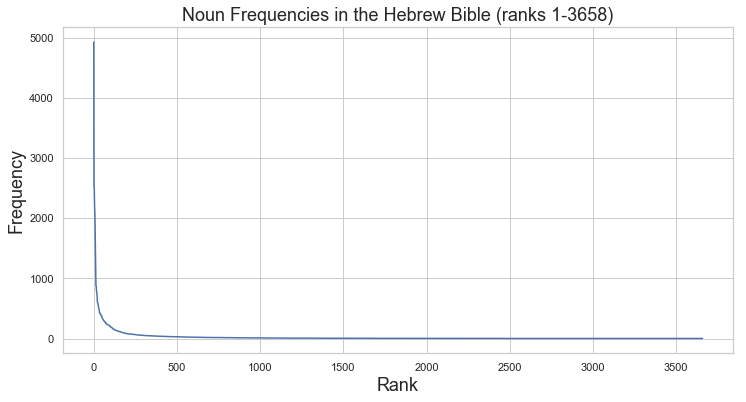

In [7]:
# plot data
y_freqs = [lex_data[0] for lex_data in noun_dat_ordered]
x_rank = [i+1 for i in range(0, len(y_freqs))]
title = 'Noun Frequencies in the Hebrew Bible'
xlabel = 'Rank'
ylabel = 'Frequency'

# first plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank, y_freqs)
plt.title(title + f' (ranks 1-{len(x_rank)})', size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

We zoom in closer to view ranks 1-1000...

*Consider using a subplot here with 4 different zooms*

[]

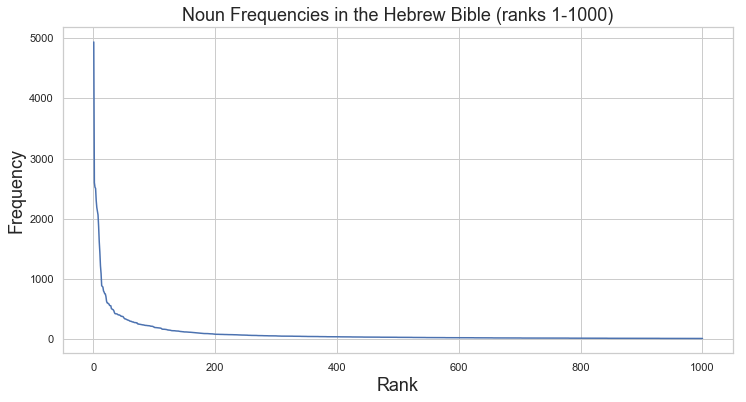

In [8]:
# second plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank[:1000], y_freqs[:1000])
plt.title(title + f' (ranks 1-1000)', size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

This curve is typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve sharply "elbows" at around rank 15. Between ranks 50-100 there is still an appreciable drop-off. The curve starts to significantly flatten after 200. We thus decide an arbitrary cut-off point at rank 200, based on the fact that the curve does not show any significant leveling after this point.

In [9]:
target_nouns = nnodes_ordered[:200]
tnoun_instances = set(word for lex in target_nouns for word in L.d(lex, 'word'))

show_word_list(target_nouns) # temporary comment out while bug is fixed
print(f'\n{len(tnoun_instances)} nouns ready for searches')


73991 nouns ready for searches


## Strategy for Context Selection

See [pyscripts/contextparameters.py](pyscripts/contextparameters.py) for the full delineation of these patterns and to see how they've been selected and tokenized. **This is a work in progress.**

* phrase-type relations
    * PP and their objcs

* subphrase relations
    * parallel (`par`) — syndetic connections
    * regens/rectum (`rec`) — nomen regens/rectum relations
    * adjunct (`adj`)
    * attribute (`atr`)
    

* phrase_atom relations
    * apposition (`appo`) — re-identification relations
    * parallel and link, what is the difference here?
    * specification, what is it?
    
    
* clause-constituent relations
    * "is a" relations with היה (subjects || predicate complements)
    * all other predicate / function roles — FRAMES

In [10]:
contexts = deliver_params(tnoun_instances, tf=api)

In [11]:
print('The following contextual relations will be queried (. without lex = target noun; -> = relation):')
for i, param in enumerate(contexts):
    name = param['name']
    print(f'{i+1}. {name}')

The following contextual relations will be queried (. without lex = target noun; -> = relation):
1. funct.-> st.verb.lex
2. funct.prep-> st.verb.lex
3. PreC.lex-> Subj.
4. PreC.prep.lex-> Subj.
5. PreC.-> Subj.lex
6. PreC.-> Subj.prep.lex
7. par.lex-> .
8. par.-> lex
9. atr.lex -> .
10. rec.lex -> .
11. rec.-> lex
12. Para.lex-> .
13. Para.-> lex
14. Appo.lex-> .
15. Appo.-> lex


In [12]:
counts = ContextCounter(contexts, tf=api, report=True)

running query on template [ funct.-> st.verb.lex ]...
	19276 results found.
running query on template [ funct.prep-> st.verb.lex ]...
	14935 results found.
running query on template [ PreC.lex-> Subj. ]...
	2559 results found.
running query on template [ PreC.prep.lex-> Subj. ]...
	1125 results found.
running query on template [ PreC.-> Subj.lex ]...
	964 results found.
running query on template [ PreC.-> Subj.prep.lex ]...
	4 results found.
running query on template [ par.lex-> . ]...
	2121 results found.
running query on template [ par.-> lex ]...
	2037 results found.
running query on template [ atr.lex -> . ]...
	1507 results found.
running query on template [ rec.lex -> . ]...
	1435 results found.
running query on template [ rec.-> lex ]...
	1692 results found.
running query on template [ Para.lex-> . ]...
	669 results found.
running query on template [ Para.-> lex ]...
	596 results found.
running query on template [ Appo.lex-> . ]...
	1410 results found.
running query on template 

Below we look at the number of dimensions in the data:

In [13]:
counts.data.shape

(12202, 199)

And a sample of the data is below:

In [14]:
counts.data.head()

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.<LH[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.<TR[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.BW>[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.CLK[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.JBL[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that one of the original target lexemes have been omitted because they fell below the 10 observation threshold. Let's see which ones they are.

In [15]:
set(F.lex.v(w) for w in tnoun_instances) - set(F.lex.v(counts.target2node[token]) for token in counts.data.columns)

{'N>M/'}

The noun נאֻם is omitted due to lack of relevant data. We thus continue with **199 target nouns.**

Next we look at a few example counts:

In [16]:
counts.data['>LHJM/'][counts.data['>LHJM/'] > 0].sort_values(ascending=False)

Appo.-> JHWH/           730.0
atr.>XR=/-> .            61.0
Subj.-> qal.>MR[         50.0
Subj.-> qal.NTN[         32.0
Objc.-> qal.<BD[         29.0
Subj.-> qal.<FH[         23.0
Appo.>LHJM/-> .          18.0
Appo.-> >LHJM/           18.0
Cmpl.>XR/-> qal.HLK[     15.0
Subj.-> qal.R>H[         13.0
Objc.-> qal.JR>[         13.0
Subj.-> piel.DBR[        12.0
PreC.B-> Subj.           11.0
PreC.-> Subj.JHWH/       11.0
Subj.-> qal.CM<[         10.0
Subj.-> piel.BRK[         9.0
Objc.-> qal.<FH[          9.0
Subj.-> qal.BW>[          8.0
Appo.-> PNH/              8.0
Cmpl.>L-> qal.>MR[        8.0
Subj.-> hif.NYL[          8.0
Subj.-> piel.YWH[         7.0
Objc.-> qal.DRC[          7.0
Cmpl.L-> piel.QVR[        7.0
Cmpl.B-> qal.C>L[         7.0
Subj.-> qal.CLX[          7.0
Objc.-> piel.BRK[         7.0
Subj.-> qal.BR>[          6.0
Cmpl.L-> qal.ZBX[         6.0
Objc.-> qal.R>H[          6.0
                        ...  
Subj.-> hif.NKH[          1.0
Subj.-> hif.NWX[          1.0
Subj.-> hi

This gives a good idea of the content of the co-occurrence counts.

## Adjusting the Counts

We will apply two primary adjustments:

1. We drop co-occurrences that are unique to a noun. The dropped observations will thus be considered outliers. While these items are useful for describing the uniqueness of a given lexeme, they are unhelpful for drawing comparisons between our sets. 
2. We convert the counts into a measure of statistical significance. For this we use Fisher's exact test, which is ideal for datasets that have counts that are less than 5. Our matrix is likely to have many such counts. The resulting p-values, of which <0.05 represents a statistically significant colexeme, will be log-transformed. Values that fall below expected frequencies will be negatively transformed.

### Remove Co-occurrence Outliers

We will remove colexemes/bases that occur with only one target noun. This is done by subtracting the row total from each item in the row. Any 0 value in a row means that that row has a unique colexeme that only occurs with one target noun (we will call that a `hapax_colex` here). We will remove these rows further down.

In [17]:
colex_counts = counts.data.sum(1)
remaining_counts = counts.data.sub(colex_counts, axis=0) # subtract colex_counts
hapax_colex = remaining_counts[(remaining_counts == 0).any(1)] # select rows that have a 0 value anywhere

Below is an example just to make sure we've selected the right indices. The value has been manually chosen from `hapax_colex`.

In [18]:
counts.data.loc['rec.XTN/-> .'].sort_values(ascending=False).head()

QWL/     8.0
RB=/     0.0
JJN/     0.0
>B/      0.0
ML>K/    0.0
Name: rec.XTN/-> ., dtype: float64

Indeed this basis element is only attested with קול, thus it is not useful for drawing meaningful comparisons to this noun. Below we see that there are `8191` other such basis elements. We remove these data points in the next cell and name the new dataset `data`.

In [19]:
hapax_colex.shape

(8191, 199)

In [20]:
data = counts.data.drop(labels=hapax_colex.index, axis=0)

print(f'New data dimensions: {data.shape}')
print(f'New total observations: {data.sum().sum()}')
print(f'Observations removed: {counts.data.sum().sum() - data.sum().sum()}')

New data dimensions: (4011, 199)
New total observations: 42097.0
Observations removed: 11870.0


Random example to make sure there are no unique colexemes in the new dataset:

In [21]:
data.loc['Adju.-> hif.BW>['].sort_values(ascending=False).head(5)

KLJ/     1.0
ZHB/     1.0
>JL=/    1.0
KSP/     1.0
RB=/     0.0
Name: Adju.-> hif.BW>[, dtype: float64

#### Check for Orphaned Target Nouns

I want to see if any target nouns in the dataset now have 0 basis observations (i.e. "orphaned") as a result of our data pruning. The test below shows that there is no columns in the table with a sum of 0.

In [22]:
data.loc[:, (data == 0).all(0)].shape

(4011, 0)

### Apply Fisher's Exact Test

Now we apply the Fisher's exact test to the data set. This involves supplying values to a 2x2 contingency table that is fed to `scipy.stats.fisher_exact`

In [23]:
# data for contingency tables
target_obs = data.apply(lambda col: col.sum(), axis=0, result_type='broadcast') # total target lexeme observations
colex_obs = data.apply(lambda col: col.sum(), axis=1, result_type='broadcast') # total colexeme/basis observations
total_obs = data.sum().sum() # total observations

# parts of contingency formula; a=data
b_matrix = target_obs.sub(data)
c_matrix = colex_obs.sub(data)
d_matrix = pd.DataFrame.copy(data, deep=True)
d_matrix[:] = total_obs
d_matrix = d_matrix.sub(data+b_matrix+c_matrix)

fisher_transformed = collections.defaultdict(lambda: collections.defaultdict())

i = 0
for lex in data.columns:
    for colex in data.index:
        a = data[lex][colex]
        b = b_matrix[lex][colex]
        c = c_matrix[lex][colex]
        d = d_matrix[lex][colex]
        contingency = np.matrix([[a, b], [c, d]])
        oddsratio, pvalue = stats.fisher_exact(contingency)
        fisher_transformed[lex][colex] = pvalue
        i += 1
        if i % 100000 == 0: # update every 100,000 iterations; should be 798,189 total (4011x199)
            print(f'finished iteration {i}...')
print('done!')

fisherdata = pd.DataFrame(fisher_transformed)

finished iteration 100000...
finished iteration 200000...
finished iteration 300000...
finished iteration 400000...
finished iteration 500000...
finished iteration 600000...
finished iteration 700000...
done!


In [24]:
fisherdata.head(10)

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.BW>[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> hif.NKH[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> nif.>SP[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> nif.CMM[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> piel.DBR[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.<BD[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.022237,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.<FH[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.HLK[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.JCB[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.JLD[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.030891,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Now we apply the log10 transformation.

In [25]:
expectedfreqs = (data+b_matrix) * (data+c_matrix) / (data+b_matrix+c_matrix+d_matrix)
fishertransf = collections.defaultdict(lambda: collections.defaultdict())

for lex in data.columns:
    for colex in data.index:
        observed_freq = data[lex][colex]
        exp_freq = expectedfreqs[lex][colex]
        pvalue = fisherdata[lex][colex]
        if observed_freq < exp_freq:
            logv = np.log10(pvalue)
            fishertransf[lex][colex] = logv
        else:
            logv = -np.log10(pvalue)
            fishertransf[lex][colex] = logv
            
fishertransf = pd.DataFrame(fishertransf)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


The Fisher's test has produced a zero value, indicating a very high degree of attraction between a lexeme and a colexeme. A log-transformed zero equals `infinity`. Below that value is isolated to the target noun אלהים and its colexeme יהוה used in an appositional relation. This makes complete sense given the identity of these two nouns in the Hebrew Bible.

In [26]:
fishertransf[(fishertransf == np.inf).any(1)]

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Appo.-> JHWH/,inf,-10.444067,-0.188674,-7.527944,-0.558846,-1.079012,-2.260869,-0.744413,-1.405128,-3.13475,...,-0.188674,0.0,-0.197103,-1.262735,-0.195528,0.0,-0.747468,-0.193768,-0.189764,-0.201185


In this case the Fisher's has returned a zero value. A p-value of 0 means that the likelihood אלהים and יהוה are *not* dependent variables is essentially null. We can thus reject the null hypothesis that the two values are not related. There is, rather, a maximum level of confidence that these two values *are* interrelated. The `np.inf` value that resulted from `log10(0)` is not viable for calculating vector distances. Thus, we need to substitute an arbitrary, but appropriate value. Below we access the lowest p-values in the dataset.

In [27]:
fisherdata.min().sort_values().head(5)

>LHJM/     0.000000e+00
QWL/      3.702549e-185
JD/       1.105410e-173
CM/       2.538751e-159
BRJT/     9.741601e-128
dtype: float64

As indicated, קול has the lowest possible p-value. Let's look at its associated basis elements.

In [28]:
fisherdata['QWL/'].sort_values().head(10)

Cmpl.B-> qal.CM<[    3.702549e-185
Objc.-> qal.CM<[      3.058807e-75
par.QWL/-> .          4.815789e-54
par.-> QWL/           7.148912e-53
Subj.-> nif.CM<[      6.055859e-37
Cmpl.L-> qal.CM<[     2.072559e-26
Objc.-> hif.CM<[      5.654931e-17
atr.GDWL/-> .         1.536830e-16
rec.FMXH/-> .         2.362351e-15
Objc.-> hif.RWM[      2.418830e-13
Name: QWL/, dtype: float64

These values are greatly expected to be associated with קול ("voice/sound". For instance, the term is used frequently as a complement, object, and subject of various stems of שמע ("to hear/cause to be heard"). It is also used in construct with שמחה ("joy").

Since `Cmpl.B-> qal.CM<[` has the lowest p-value in the dataset (an extremely tiny number: 3.702549 preceded by 185 zeros), it is an appropriate substitute for the p-value of 0 found between אלהים and its appositional יהוה. We make the substitution below for both `fisherdata` and the log-transformed p-values in `fishertransf`.

In [29]:
fisherdata['>LHJM/']['Appo.-> JHWH/'] = fisherdata['QWL/']['Cmpl.B-> qal.CM<[']
fishertransf['>LHJM/']['Appo.-> JHWH/'] = fishertransf['QWL/']['Cmpl.B-> qal.CM<[']

for change in (fisherdata['>LHJM/']['Appo.-> JHWH/'], fishertransf['>LHJM/']['Appo.-> JHWH/']):
    print(change)

3.702548760652347e-185
184.43149921333537


<hr>

#### Excursus: A Random Sample Examined

We saw that the model seems to be succeeding at isolating intuitive associations with קול. Let's look at another example at random, in this case the noun ארץ ("land"). Below are the transformed p-values for that noun.

In [30]:
fishertransf['>RY/'].sort_values(ascending=False).head(10)

Objc.-> qal.JRC[      51.356095
Cmpl.MN-> hif.JY>[    39.624520
rec.-> <M/            35.730752
rec.-> JCB[           25.798726
rec.-> MMLKH/         25.523038
Cmpl.MN-> hif.<LH[    23.751387
Cmpl.B-> qal.JCB[     20.472499
Appo.>RY/-> .         15.229357
Cmpl.>L-> hif.BW>[    13.731685
Appo.-> >RY/          13.658245
Name: >RY/, dtype: float64

The most associated variables include cases where ארץ is an object to the verb ירשׁ, where ארץ serves as the complement from which something is brought (hifil of יצא and hifil of עלה), frequently in construct to >M (עם, "people"), JCB (probably the participle of ישב, "inhabitant(s)"), and MMlH (ממלכה, "kingdom"), as well as other satisfying and expected occasions of use. These examples show that the model is working well.
<hr>

## Comparing the Nouns

The nouns are now ready to be compared. I will do so in two ways.

1. Principle Component Analysis — We have a semantic space with 4,011 dimensions. That is a lot of potential angles from which to compare the vectors. One method that is commonly used in semantic space analysis is principle component analysis or **PCA**. PCA is a dimensionality reduction method that reduce a multi-dimensional vector to the two points in an imagined space that show the most distance between the nouns. We can visualize said space by plotting the two points on an X and Y axis.
2. Cosine Similarity — This measure allows us to compare the vectors on the basis of their trajectories. This method is particularly well-suited for semantic spaces because it ignores differences in frequency and compares, rather, the closeness of relationship between two sets of frequencies. 

### PCA Analysis

We want to apply PCA in order to plot nouns in an imaginary space. The goal is to use the visualization to identify patterns and groups amongst the 199 target nouns. Nouns that are more similar should fall within the same general areas relative to the origin (0, 0). PCA seeks to identify the maximum variance amongst the vector spaces. 

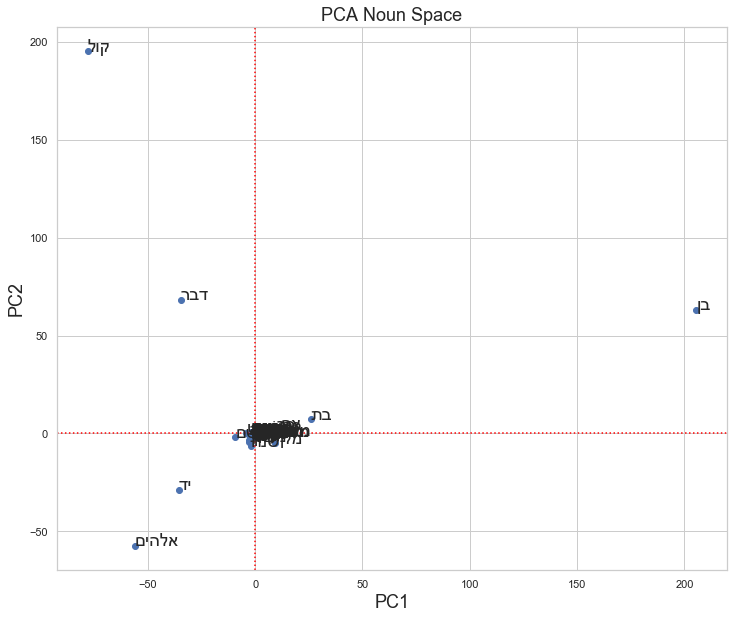

In [31]:
pca = PCA(3) # PCA with 3 principal components
pca_nouns = pca.fit_transform(fishertransf.T.values) # get coordinates

def plot_PCA(pca_nouns, zoom=tuple()):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    # plot coordinates
    plt.figure(figsize=(12, 10))
    plt.scatter(pca_nouns[:, 0], pca_nouns[:, 1])

    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        
    plt.title('PCA Noun Space', size=18)
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')

    # annotate points
    noun_lexs = [f'{reverse_hb(F.lex_utf8.v(counts.target2node[n]))}' for n in fishertransf.columns]
    for i, noun in enumerate(noun_lexs):
        x, y = pca_nouns[i, 0], pca_nouns[i, 1]
        
        if zoom: # to avoid annotating outside of field of view (makes plot small)
            if any([x < xmin, x > xmax, y < ymin, y > ymax]):                
                continue # skip noun

        plt.annotate(noun, xy=(x, y), size='18')
        
    plt.show()
        
plot_PCA(pca_nouns)

We can already see some interesting tendencies in the data. קול and דבר are grouped in the same quadrant. In the upper right quadrant we see בן and בת. The lower left quadrant presents a particularly interesting match: יד "hand" and אלהים "God".

We zoom in closer below to have a better look at the tendencies.

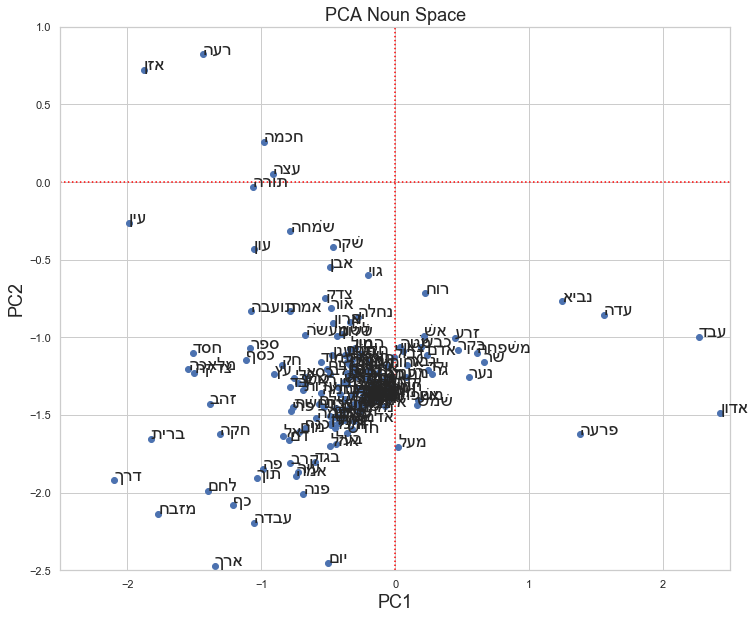

In [32]:
plot_PCA(pca_nouns, zoom=((-2.5, 2.5, -2.5, 1)))

Note that nouns in the lower right quadrant tend to be people, while on the lower left there are primarily things.

The plot below shows person nouns.

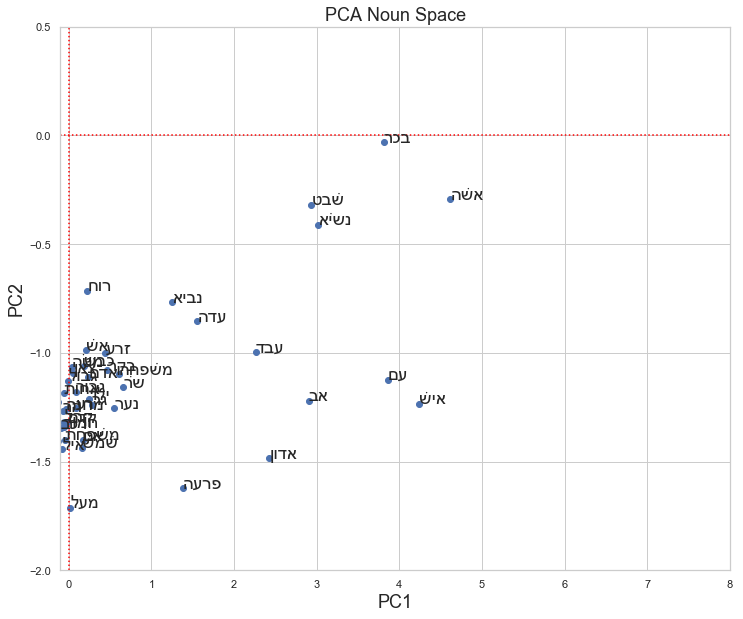

In [303]:
plot_PCA(pca_nouns, zoom=((-0.1, 8, -2, 0.5)))

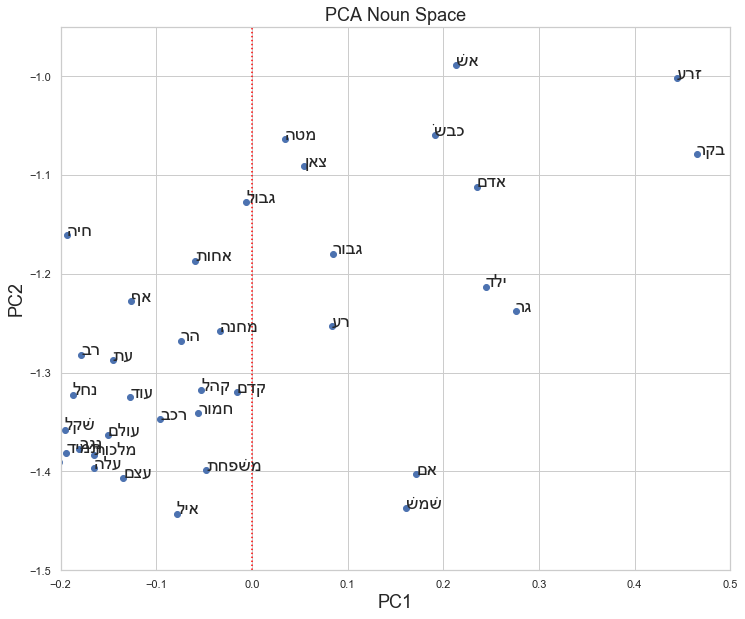

In [41]:
plot_PCA(pca_nouns, zoom=((-0.2, 0.5, -1.5, -0.95)))

The next plot shows nouns to the left of the y-origin. Note especially the terms between y(-0.5) and y(0.0.). These are more conceptual nouns. This same trajectory extends up into the far parts of the upper left quadrant through דבר and קול.

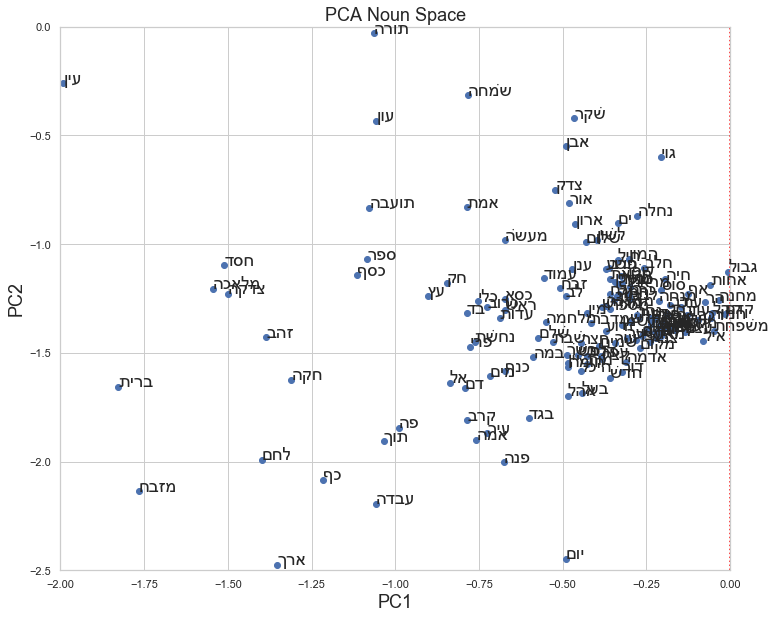

In [296]:
plot_PCA(pca_nouns, zoom=((-2, 0, -2.5, 0)))

Here is a closer look at the larger cluster near the left side of the y-origin.

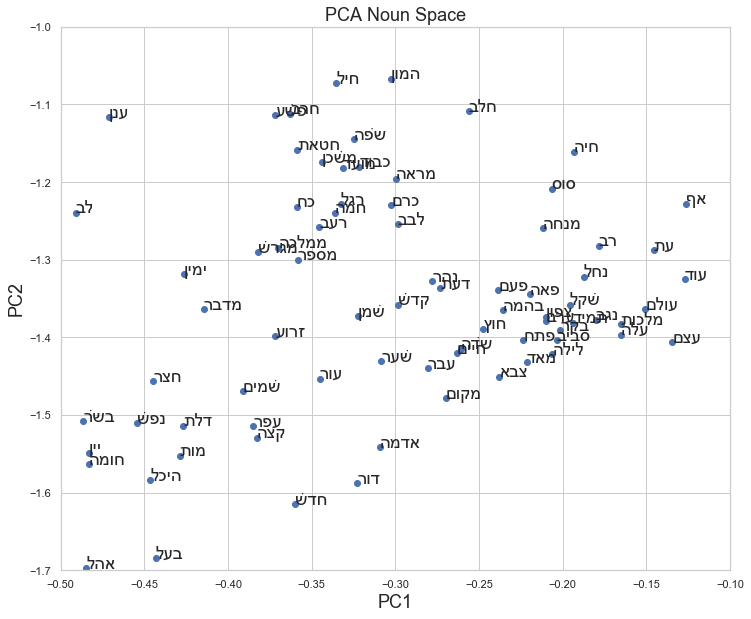

In [42]:
plot_PCA(pca_nouns, zoom=((-0.5, -0.1, -1.7, -1)))

Some important tendencies emerge in the PCA plot. In general, person-nouns tend to fall to the right of the vertical axis while things and ideas fall on the left.

### Cosine Similarity Rankings

In [47]:
distances_raw = pairwise_distances(fishertransf.T.values, metric='cosine')
distances = pd.DataFrame(distances_raw, columns=fishertransf.columns, index=fishertransf.columns)
similarities = distances.apply(lambda n: 1-n) # convert distance matrix to similarities.

### Make Subplots

### Preview Similarities

In [78]:
for noun in similarities.columns:
    
    sims = similarities[noun].sort_values(ascending=False).head(11)[1:]
    sim_values = sims.values
    lexemes = [F.lex_utf8.v(counts.target2node[noun]) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    sims_new = pd.DataFrame(sim_values, index=lex_glosses)
    
    print(F.lex_utf8.v(counts.target2node[noun]), counts.target2gloss[noun])
    display(sims_new)
    print('\n')
    print('-'*25)

אלהים god(s)


,0
אל 'god',0.075407
"בעל 'lord, baal'",0.068468
עבדה 'work',0.061717
דור 'generation',0.050641
כנף 'wing',0.019485
אדמה 'soil',0.006060
פרעה 'pharaoh',0.003639
לשׁון 'tongue',0.001580
זרוע 'arm',0.000461
תמיד 'continuity',0.000276




-------------------------
ארץ earth


,0
קרב 'interior',0.172128
מחנה 'camp',0.153013
תוך 'midst',0.149481
עיר 'town',0.135407
מדבר 'desert',0.121462
מקום 'place',0.104750
אהל 'tent',0.104548
נחלה 'heritage',0.097267
היכל 'palace',0.095118
אדמה 'soil',0.090545




-------------------------
אור light


,0
שׁמשׁ 'sun',0.188235
רעה 'evil',0.093670
מראה 'sight',0.093178
המון 'commotion',0.075589
אל 'god',0.072023
חכמה 'wisdom',0.071826
מעשׂה 'deed',0.061478
קדשׁ 'holiness',0.060918
כנף 'wing',0.059987
אבן 'stone',0.059583




-------------------------
יום day


,0
חדשׁ 'month',0.314642
לילה 'night',0.252122
עת 'time',0.250407
בקר 'morning',0.143708
ערב 'evening',0.134627
מספר 'number',0.128665
תמיד 'continuity',0.089371
עולם 'eternity',0.075674
גוי 'people',0.059861
עצם 'bone',0.058658




-------------------------
לילה night


,0
יום 'day',0.252122
חדשׁ 'month',0.119755
בקר 'morning',0.073402
תמיד 'continuity',0.050959
שׁנה 'year',0.016974
ערב 'evening',0.015484
עולם 'eternity',0.015195
עת 'time',0.011662
אור 'light',0.011448
קדשׁ 'holiness',0.010334




-------------------------
שׁמים heavens


,0
הר 'mountain',0.209325
צבא 'service',0.150176
היכל 'palace',0.061881
במה 'high place',0.055233
ים 'sea',0.043302
אהל 'tent',0.038432
כח 'strength',0.037586
רוח 'wind',0.035292
ארץ 'earth',0.033998
חדשׁ 'month',0.027536




-------------------------
מים water


,0
יין 'wine',0.645139
גוי 'people',0.096244
דם 'blood',0.087184
קהל 'assembly',0.077010
המון 'commotion',0.069996
נחל 'wadi',0.049224
יום 'day',0.037103
עם 'people',0.033369
רע 'fellow',0.032425
נפשׁ 'soul',0.031398




-------------------------
ים sea


,0
צפון 'north',0.129047
דור 'generation',0.117830
נהר 'stream',0.109173
קדם 'front',0.108717
נגב 'south',0.088127
מדבר 'desert',0.087452
שׂמחה 'joy',0.081224
ענן 'cloud',0.071632
נחל 'wadi',0.068426
רעה 'evil',0.063721




-------------------------
עץ tree


,0
חיה 'wild animal',0.254704
מלאכה 'work',0.191038
משׁפט 'justice',0.138588
תועבה 'abomination',0.136085
אבן 'stone',0.135358
נחשׁת 'bronze',0.134001
עמוד 'pillar',0.122523
כרוב 'cherub',0.118941
"בד 'linen, part, stave'",0.113807
ברית 'covenant',0.112156




-------------------------
נפשׁ soul


,0
ילד 'boy',0.144254
בכר 'first-born',0.105885
אישׁ 'man',0.088741
לבב 'heart',0.081842
לשׁון 'tongue',0.071889
עצם 'bone',0.061132
שׁלום 'peace',0.060232
זרע 'seed',0.056226
רוח 'wind',0.052678
חכמה 'wisdom',0.045146




-------------------------
חיה wild animal


,0
עץ 'tree',0.254704
ממלכה 'kingdom',0.111898
בהמה 'cattle',0.108817
אשׁ 'fire',0.092702
רוח 'wind',0.046495
עם 'people',0.038186
"אדם 'human, mankind'",0.037841
המון 'commotion',0.026931
דרך 'way',0.026090
זרע 'seed',0.025813




-------------------------
אדם human, mankind


,0
בהמה 'cattle',0.099958
אישׁ 'man',0.070477
גוי 'people',0.053748
קדם 'front',0.052860
חמור 'he-ass',0.049551
זרע 'seed',0.048866
בשׂר 'flesh',0.045408
פרעה 'pharaoh',0.043561
נער 'boy',0.041004
המון 'commotion',0.038811




-------------------------
צבא service


,0
שׁמים 'heavens',0.150176
רוח 'wind',0.134346
חיל 'power',0.074051
מלאך 'messenger',0.035437
חיים 'life',0.029241
שׁמשׁ 'sun',0.027902
משׁפחה 'clan',0.024822
קהל 'assembly',0.021356
נער 'boy',0.018250
תוך 'midst',0.017745




-------------------------
אדמה soil


,0
כסא 'seat',0.271101
עבדה 'work',0.117217
פתח 'opening',0.113912
מקום 'place',0.107979
עץ 'tree',0.092788
ארץ 'earth',0.090545
שׂדה 'open field',0.075943
עפר 'dust',0.072416
מחנה 'camp',0.069094
בהמה 'cattle',0.065656




-------------------------
פנה face


,0
זרע 'seed',0.090357
מלחמה 'war',0.075535
ימין 'right-hand side',0.044580
אור 'light',0.042253
ראשׁ 'head',0.040577
משׁפחה 'clan',0.039392
עון 'sin',0.038927
עין 'eye',0.038715
אהל 'tent',0.037529
שׁבט 'rod',0.036967




-------------------------
עפר dust


,0
עלה 'burnt-offering',0.177909
דם 'blood',0.150766
אבן 'stone',0.110370
ארון 'ark',0.108693
מנחה 'present',0.101508
מחנה 'camp',0.094195
לחם 'bread',0.091247
בשׂר 'flesh',0.087393
פרי 'fruit',0.081604
שׁלם 'final offer',0.080837




-------------------------
שׁם name


,0
ספר 'letter',0.136107
מועד 'appointment',0.058669
אל 'god',0.058252
אזן 'ear',0.056336
שׁבת 'sabbath',0.039956
דבר 'word',0.029843
זרע 'seed',0.029842
"בעל 'lord, baal'",0.027722
קדשׁ 'holiness',0.024937
נחל 'wadi',0.024604




-------------------------
בשׂר flesh


,0
לחם 'bread',0.728351
פרי 'fruit',0.560275
רגל 'foot',0.340849
קדשׁ 'holiness',0.146313
חלב 'fat',0.105049
עפר 'dust',0.087393
דם 'blood',0.080746
פאה 'corner',0.080698
חטאת 'sin',0.069384
קרב 'interior',0.069166




-------------------------
אשׁה woman


,0
מטה 'staff',0.269552
אישׁ 'man',0.196729
ילד 'boy',0.162866
חמור 'he-ass',0.108700
מנחה 'present',0.106855
בת 'daughter',0.105944
אחות 'sister',0.081199
אבן 'stone',0.079704
ארון 'ark',0.068795
צאן 'cattle',0.066595




-------------------------
אישׁ man


,0
אשׁה 'woman',0.196729
גבור 'vigorous',0.177114
נער 'boy',0.161527
מלך 'king',0.129495
עבד 'servant',0.118338
עם 'people',0.113397
מלאך 'messenger',0.105715
שׂר 'chief',0.102908
ילד 'boy',0.094206
נפשׁ 'soul',0.088741




-------------------------
אם mother


,0
אח 'brother',0.093701
ילד 'boy',0.067549
פרעה 'pharaoh',0.054770
מלך 'king',0.050089
אשׁה 'woman',0.041182
אחות 'sister',0.038489
נער 'boy',0.036823
אב 'father',0.035491
מטה 'staff',0.032253
אישׁ 'man',0.031306




-------------------------
עין eye


,0
עון 'sin',0.342491
ארון 'ark',0.216631
ראשׁ 'head',0.169885
כנף 'wing',0.081835
היכל 'palace',0.071198
כהן 'priest',0.070328
שׂדה 'open field',0.056783
חטאת 'sin',0.042937
מספר 'number',0.041166
פנה 'face',0.038715




-------------------------
קול sound


,0
דבר 'word',0.257185
חכמה 'wisdom',0.060219
עצה 'counsel',0.059438
שׂמחה 'joy',0.046729
תורה 'instruction',0.040943
רעה 'evil',0.038796
אזן 'ear',0.037125
אור 'light',0.034273
עון 'sin',0.030875
המון 'commotion',0.021958




-------------------------
ראשׁ head


,0
עון 'sin',0.282383
ארון 'ark',0.223413
פאה 'corner',0.170025
עין 'eye',0.169885
כף 'palm',0.118300
יד 'hand',0.115975
כנף 'wing',0.089248
הר 'mountain',0.074199
מזבח 'altar',0.072436
לב 'heart',0.052249




-------------------------
בן son


,0
בת 'daughter',0.330988
אח 'brother',0.296023
נשׂיא 'chief',0.149783
בכר 'first-born',0.140030
פר 'young bull',0.122775
כהן 'priest',0.117888
שׁבט 'rod',0.096905
אשׁה 'woman',0.051727
משׁפחה 'clan',0.048532
נביא 'prophet',0.042682




-------------------------
לחם bread


,0
בשׂר 'flesh',0.728351
פרי 'fruit',0.702927
חלב 'fat',0.141320
קדשׁ 'holiness',0.139869
שׁמן 'oil',0.117947
פאה 'corner',0.103210
דם 'blood',0.097506
עפר 'dust',0.091247
"בד 'linen, part, stave'",0.078772
כח 'strength',0.064172




-------------------------
יד hand


,0
כף 'palm',0.184799
מלאך 'messenger',0.170786
מות 'death',0.151150
תוך 'midst',0.135718
ראשׁ 'head',0.115975
קרב 'interior',0.085941
אהל 'tent',0.058843
ספר 'letter',0.051031
קצה 'end',0.050916
פה 'mouth',0.049795




-------------------------
דרך way


,0
חקה 'regulation',0.514048
תורה 'instruction',0.342376
חטאת 'sin',0.298769
מדבר 'desert',0.253636
עצה 'counsel',0.113867
חק 'portion',0.104216
עדות 'reminder',0.077569
שׁקר 'lie',0.063830
מצוה 'commandment',0.060807
אור 'light',0.043082




-------------------------
אח brother


,0
בת 'daughter',0.414822
בן 'son',0.296023
שׁבט 'rod',0.154081
נער 'boy',0.127591
אם 'mother',0.093701
בכר 'first-born',0.076631
כהן 'priest',0.072281
שׁמשׁ 'sun',0.064704
אישׁ 'man',0.059203
אשׁה 'woman',0.058155




-------------------------
מנחה present


,0
עלה 'burnt-offering',0.506937
שׁלם 'final offer',0.504067
ארון 'ark',0.338201
זבח 'sacrifice',0.140133
חלב 'fat',0.120503
כבשׂ 'young ram',0.118736
מטה 'staff',0.113218
פר 'young bull',0.107370
אשׁה 'woman',0.106855
משׁפחת 'clan',0.101751




-------------------------
מאד might


,0
עוד 'duration',0.147913
תמיד 'continuity',0.039759
סביב 'surrounding',0.029556
פעם 'foot',0.023953
שׁלום 'peace',0.014994
רב 'multitude',0.013585
לבב 'heart',0.010897
חקה 'regulation',0.010808
קדם 'front',0.007910
כסא 'seat',0.006939




-------------------------
פה mouth


,0
דלת 'door',0.216521
שׂפה 'lip',0.212037
שׁער 'gate',0.089605
לשׁון 'tongue',0.062314
נחל 'wadi',0.059870
תוך 'midst',0.054203
נהר 'stream',0.053984
כף 'palm',0.051420
יד 'hand',0.049795
קרב 'interior',0.040657




-------------------------
דם blood


,0
חמה 'heat',0.501799
עפר 'dust',0.150766
לחם 'bread',0.097506
יין 'wine',0.095213
פרי 'fruit',0.092456
מים 'water',0.087184
רוח 'wind',0.081956
בשׂר 'flesh',0.080746
שׁמן 'oil',0.075205
קצה 'end',0.058433




-------------------------
כח strength


,0
זרוע 'arm',0.146503
לבב 'heart',0.097567
חמה 'heat',0.094203
במה 'high place',0.091715
שׂמחה 'joy',0.087437
מועד 'appointment',0.076764
מספר 'number',0.068148
רוח 'wind',0.067226
מעשׂה 'deed',0.065832
עצה 'counsel',0.064388




-------------------------
עוד duration


,0
סביב 'surrounding',0.274205
פעם 'foot',0.205532
מאד 'might',0.147913
תמיד 'continuity',0.109969
קדם 'front',0.048069
נגב 'south',0.036433
צפון 'north',0.027628
בקר 'morning',0.020300
ערב 'evening',0.014305
חוץ 'outside',0.013461




-------------------------
זרע seed


,0
נחלה 'heritage',0.119926
שׁבט 'rod',0.112826
רע 'fellow',0.094707
פנה 'face',0.090357
מטה 'staff',0.081301
מעל 'top',0.066846
שׂדה 'open field',0.063056
משׁכן 'dwelling-place',0.060230
גר 'sojourner',0.058649
כרם 'vineyard',0.057270




-------------------------
שׁנה year


,0
חדשׁ 'month',0.321205
יום 'day',0.053322
שׁבת 'sabbath',0.041483
עת 'time',0.036083
לילה 'night',0.016974
בקר 'morning',0.016207
ערב 'evening',0.015559
תמיד 'continuity',0.007841
עולם 'eternity',0.006420
דור 'generation',0.005801




-------------------------
בת daughter


,0
אח 'brother',0.414822
בן 'son',0.330988
שׁבט 'rod',0.219028
אחות 'sister',0.106671
אשׁה 'woman',0.105944
זרע 'seed',0.049555
משׁפחת 'clan',0.048183
מטה 'staff',0.047196
ילד 'boy',0.038550
מגרשׁ 'pasture',0.037438




-------------------------
רוח wind


,0
צבא 'service',0.134346
חמה 'heat',0.113557
נהר 'stream',0.097281
דם 'blood',0.081956
כרוב 'cherub',0.075233
פאה 'corner',0.074241
כח 'strength',0.067226
מלכות 'kingship',0.060911
חכמה 'wisdom',0.060181
לב 'heart',0.059997




-------------------------
פתח opening


,0
אהל 'tent',0.121465
אדמה 'soil',0.113912
מקום 'place',0.092245
ארץ 'earth',0.077517
מחנה 'camp',0.073140
משׁכן 'dwelling-place',0.069653
שׁער 'gate',0.065217
היכל 'palace',0.064701
מדבר 'desert',0.052170
חצר 'court',0.050260




-------------------------
ברית covenant


,0
כנף 'wing',0.183794
עצה 'counsel',0.134213
עץ 'tree',0.112156
תורה 'instruction',0.060674
ראשׁ 'head',0.050238
משׁכן 'dwelling-place',0.048924
מצוה 'commandment',0.041569
עדות 'reminder',0.036004
נחל 'wadi',0.035771
עמוד 'pillar',0.033408




-------------------------
הר mountain


,0
שׁמים 'heavens',0.209325
מדבר 'desert',0.189738
עבר 'opposite',0.136668
ארץ 'earth',0.089432
במה 'high place',0.086272
נגב 'south',0.081736
בית 'house',0.075347
ראשׁ 'head',0.074199
עיר 'town',0.073106
שׁער 'gate',0.070943




-------------------------
אמה cubit


,0
עץ 'tree',0.020346
ארך 'length',0.019224
גבול 'boundary',0.009662
רחב 'breadth',0.007837
מלחמה 'war',0.006822
צפון 'north',0.006257
שׂמחה 'joy',0.004381
מזבח 'altar',0.004142
קדשׁ 'holiness',0.003159
חומה 'wall',0.003059




-------------------------
בהמה cattle


,0
ממלכה 'kingdom',0.171719
חיה 'wild animal',0.108817
"אדם 'human, mankind'",0.099958
אדמה 'soil',0.065656
גוי 'people',0.060908
צאן 'cattle',0.048557
עם 'people',0.048224
המון 'commotion',0.048105
זרע 'seed',0.038751
בקר 'cattle',0.031376




-------------------------
מזבח altar


,0
בית 'house',0.563963
חומה 'wall',0.393912
במה 'high place',0.372091
היכל 'palace',0.226737
עיר 'town',0.137535
ראשׁ 'head',0.072436
שׁער 'gate',0.071575
משׁכן 'dwelling-place',0.063673
עמוד 'pillar',0.035953
מלאכה 'work',0.035182




-------------------------
עלה burnt-offering


,0
מנחה 'present',0.506937
ארון 'ark',0.444250
שׁלם 'final offer',0.422056
עפר 'dust',0.177909
עצם 'bone',0.128279
פר 'young bull',0.073982
קהל 'assembly',0.072889
כרוב 'cherub',0.070487
חלב 'fat',0.056027
מלאכה 'work',0.050006




-------------------------
ענן cloud


,0
כבוד 'weight',0.101080
כרוב 'cherub',0.072741
ים 'sea',0.071632
עמוד 'pillar',0.044224
אור 'light',0.041622
חיל 'power',0.041007
כף 'palm',0.037222
כנף 'wing',0.036467
במה 'high place',0.035928
שׂמחה 'joy',0.035349




-------------------------
כרם vineyard


,0
מגרשׁ 'pasture',0.089028
נחלה 'heritage',0.081238
עץ 'tree',0.065013
זרע 'seed',0.057270
ארץ 'earth',0.048889
אהל 'tent',0.047554
כסף 'silver',0.042054
משׁפחת 'clan',0.039104
חכמה 'wisdom',0.037640
קצה 'end',0.030518




-------------------------
משׁפחה clan


,0
פרי 'fruit',0.155590
בן 'son',0.048532
"בד 'linen, part, stave'",0.046510
שׁבט 'rod',0.043034
פנה 'face',0.039392
מלחמה 'war',0.038407
אח 'brother',0.038043
כלי 'tool',0.035596
תועבה 'abomination',0.034775
זרע 'seed',0.032661




-------------------------
גוי people


,0
המון 'commotion',0.183696
קהל 'assembly',0.158929
עם 'people',0.152996
ממלכה 'kingdom',0.150993
שׂמחה 'joy',0.124495
רעה 'evil',0.099809
מים 'water',0.096244
דור 'generation',0.081733
אל 'god',0.076489
ים 'sea',0.063111




-------------------------
עיר town


,0
בית 'house',0.247031
חומה 'wall',0.152909
מזבח 'altar',0.137535
ארץ 'earth',0.135407
אהל 'tent',0.122286
מגרשׁ 'pasture',0.117376
מחנה 'camp',0.106019
מדבר 'desert',0.094249
היכל 'palace',0.088507
במה 'high place',0.086816




-------------------------
שׂפה lip


,0
פה 'mouth',0.212037
לשׁון 'tongue',0.099876
מראה 'sight',0.097714
דלת 'door',0.086818
משׁכן 'dwelling-place',0.081669
תורה 'instruction',0.051406
לב 'heart',0.047509
המון 'commotion',0.043574
אדמה 'soil',0.037652
רב 'multitude',0.035785




-------------------------
אהל tent


,0
מחנה 'camp',0.328779
היכל 'palace',0.236755
תוך 'midst',0.149460
מדבר 'desert',0.148371
שׁער 'gate',0.145650
מקום 'place',0.134309
בית 'house',0.122652
עיר 'town',0.122286
פתח 'opening',0.121465
קהל 'assembly',0.116581




-------------------------
נגב south


,0
צפון 'north',0.314442
קדם 'front',0.179003
ים 'sea',0.088127
הר 'mountain',0.081736
מגרשׁ 'pasture',0.079960
ימין 'right-hand side',0.069742
מדבר 'desert',0.050165
שׁער 'gate',0.049182
קהל 'assembly',0.044995
פאה 'corner',0.040106




-------------------------
שׂר chief


,0
גבור 'vigorous',0.289940
אישׁ 'man',0.102908
מלך 'king',0.088630
עם 'people',0.077296
מלאך 'messenger',0.073879
קהל 'assembly',0.069517
נביא 'prophet',0.066354
פרעה 'pharaoh',0.062348
כהן 'priest',0.055898
עבד 'servant',0.055231




-------------------------
בית house


,0
מזבח 'altar',0.563963
במה 'high place',0.358839
חומה 'wall',0.329651
היכל 'palace',0.286126
עיר 'town',0.247031
אהל 'tent',0.122652
שׁער 'gate',0.105938
מחנה 'camp',0.103322
מדבר 'desert',0.095224
משׁפחת 'clan',0.090934




-------------------------
פרעה pharaoh


,0
אדון 'lord',0.624048
מלך 'king',0.330277
נער 'boy',0.122748
מלכות 'kingship',0.112543
עם 'people',0.086799
מחנה 'camp',0.085659
עבד 'servant',0.083839
אישׁ 'man',0.081419
מלאך 'messenger',0.075644
אהל 'tent',0.070502




-------------------------
צפון north


,0
נגב 'south',0.314442
קדם 'front',0.211537
עבר 'opposite',0.161047
ים 'sea',0.129047
אדמה 'soil',0.064024
שׂדה 'open field',0.052906
ארץ 'earth',0.047641
הר 'mountain',0.039399
חוץ 'outside',0.039078
סביב 'surrounding',0.033382




-------------------------
קדם front


,0
צפון 'north',0.211537
נגב 'south',0.179003
ים 'sea',0.108717
מדבר 'desert',0.087946
חיל 'power',0.061478
"אדם 'human, mankind'",0.052860
בקר 'cattle',0.051481
עוד 'duration',0.048069
פעם 'foot',0.043815
הר 'mountain',0.043191




-------------------------
מלחמה war


,0
חיל 'power',0.202906
שׁלום 'peace',0.157546
פנה 'face',0.075535
גבור 'vigorous',0.073049
רעב 'hunger',0.059504
עץ 'tree',0.055203
קהל 'assembly',0.046285
מטה 'staff',0.045874
אהל 'tent',0.044101
משׁפט 'justice',0.039814




-------------------------
מלך king


,0
פרעה 'pharaoh',0.330277
עבד 'servant',0.160816
אישׁ 'man',0.129495
נער 'boy',0.099258
שׂר 'chief',0.088630
עם 'people',0.070759
אשׁה 'woman',0.061876
מלאך 'messenger',0.059864
מחנה 'camp',0.051433
אם 'mother',0.050089




-------------------------
עם people


,0
ממלכה 'kingdom',0.214515
גוי 'people',0.152996
אישׁ 'man',0.113397
קהל 'assembly',0.102288
נער 'boy',0.096304
פרעה 'pharaoh',0.086799
שׂר 'chief',0.077296
מלך 'king',0.070759
עבד 'servant',0.060267
נביא 'prophet',0.057796




-------------------------
יין wine


,0
מים 'water',0.645139
דם 'blood',0.095213
נחל 'wadi',0.044525
צאן 'cattle',0.028831
שׁמן 'oil',0.023925
מנחה 'present',0.023764
משׁפחת 'clan',0.023342
חסד 'loyalty',0.014983
מספר 'number',0.012949
המון 'commotion',0.012647




-------------------------
נער boy


,0
מלאך 'messenger',0.188373
אישׁ 'man',0.161527
אח 'brother',0.127591
עבד 'servant',0.122775
פרעה 'pharaoh',0.122748
ילד 'boy',0.104087
מלך 'king',0.099258
עם 'people',0.096304
רע 'fellow',0.093865
קהל 'assembly',0.081613




-------------------------
חוץ outside


,0
שׂדה 'open field',0.121597
מדבר 'desert',0.097020
עבר 'opposite',0.060652
שׁער 'gate',0.058290
פעם 'foot',0.057948
קרב 'interior',0.054842
ארץ 'earth',0.047593
היכל 'palace',0.047248
ים 'sea',0.042159
צפון 'north',0.039078




-------------------------
צדקה justice


,0
מלאכה 'work',0.227001
משׁפט 'justice',0.189229
תועבה 'abomination',0.159685
כרוב 'cherub',0.139467
חסד 'loyalty',0.128571
"בד 'linen, part, stave'",0.120408
צדק 'justice',0.110198
עץ 'tree',0.104597
תורה 'instruction',0.098868
רעה 'evil',0.094120




-------------------------
איל ram, despot


,0
כבשׂ 'young ram',0.405303
פר 'young bull',0.086555
מנחה 'present',0.085239
צאן 'cattle',0.079313
עלה 'burnt-offering',0.044625
חמור 'he-ass',0.036609
חלב 'fat',0.034539
אשׁה 'woman',0.029853
מטה 'staff',0.029715
משׁפחת 'clan',0.022689




-------------------------
רע fellow


,0
זרע 'seed',0.094707
נער 'boy',0.093865
גר 'sojourner',0.086800
בכר 'first-born',0.071439
מעל 'top',0.065663
אישׁ 'man',0.065634
משׁפחת 'clan',0.065348
עבד 'servant',0.054449
עצה 'counsel',0.053721
עם 'people',0.051996




-------------------------
דור generation


,0
עולם 'eternity',0.161042
ים 'sea',0.117830
אישׁ 'man',0.088275
גוי 'people',0.081733
נער 'boy',0.074648
שׁמשׁ 'sun',0.070511
קצה 'end',0.056963
שׁלום 'peace',0.051930
אלהים 'god(s)',0.050641
אח 'brother',0.041026




-------------------------
שׁמשׁ sun


,0
אור 'light',0.188235
אישׁ 'man',0.083908
נער 'boy',0.079908
דור 'generation',0.070511
ארון 'ark',0.070010
אח 'brother',0.064704
רעה 'evil',0.064227
נשׂיא 'chief',0.055434
מלאך 'messenger',0.052756
כבוד 'weight',0.046658




-------------------------
מלאך messenger


,0
ספר 'letter',0.276561
נער 'boy',0.188373
יד 'hand',0.170786
קצה 'end',0.167891
עבד 'servant',0.116961
אישׁ 'man',0.105715
פרעה 'pharaoh',0.075644
שׂר 'chief',0.073879
מלך 'king',0.059864
מנחה 'present',0.055826




-------------------------
אב father


,0
עבד 'servant',0.167667
במה 'high place',0.057380
זרע 'seed',0.050778
מלך 'king',0.044711
שׁקר 'lie',0.043801
פרעה 'pharaoh',0.036305
אם 'mother',0.035491
רע 'fellow',0.025680
אישׁ 'man',0.025238
"אדם 'human, mankind'",0.023852




-------------------------
נשׂיא chief


,0
בן 'son',0.149783
משׁפחת 'clan',0.146276
חסד 'loyalty',0.128534
מספר 'number',0.095157
קהל 'assembly',0.089538
שׁלום 'peace',0.080703
פר 'young bull',0.069100
כהן 'priest',0.059003
מגרשׁ 'pasture',0.057027
שׁמשׁ 'sun',0.055434




-------------------------
רגל foot


,0
בשׂר 'flesh',0.340849
קרב 'interior',0.104972
פעם 'foot',0.100990
כף 'palm',0.089274
מצוה 'commandment',0.061307
חקה 'regulation',0.053384
עדות 'reminder',0.044365
רב 'multitude',0.035246
ימין 'right-hand side',0.034021
ראשׁ 'head',0.033529




-------------------------
לב heart


,0
לבב 'heart',0.415289
אזן 'ear',0.094366
לשׁון 'tongue',0.080792
מלכות 'kingship',0.075211
זרוע 'arm',0.067105
נחלה 'heritage',0.062502
רוח 'wind',0.059997
ראשׁ 'head',0.052249
נהר 'stream',0.051001
שׂפה 'lip',0.047509




-------------------------
אדון lord


,0
פרעה 'pharaoh',0.624048
מלכות 'kingship',0.183114
אל 'god',0.042210
מלך 'king',0.039036
נער 'boy',0.035756
גבול 'boundary',0.022853
בן 'son',0.020962
עבד 'servant',0.019976
אם 'mother',0.019238
רע 'fellow',0.015819




-------------------------
דבר word


,0
שׁקר 'lie',0.260025
קול 'sound',0.257185
רעה 'evil',0.177288
עצה 'counsel',0.151353
חכמה 'wisdom',0.150443
משׁפט 'justice',0.145744
תועבה 'abomination',0.114262
צדק 'justice',0.100571
מלאכה 'work',0.094185
עמוד 'pillar',0.075951




-------------------------
משׁפט justice


,0
מצוה 'commandment',0.391199
מלאכה 'work',0.317027
חקה 'regulation',0.305504
תועבה 'abomination',0.253201
עדות 'reminder',0.247153
חק 'portion',0.232354
כרוב 'cherub',0.189999
חסד 'loyalty',0.189768
צדקה 'justice',0.189229
תורה 'instruction',0.172735




-------------------------
פעם foot


,0
עוד 'duration',0.205532
רגל 'foot',0.100990
סביב 'surrounding',0.092585
חוץ 'outside',0.057948
קדם 'front',0.043815
חכמה 'wisdom',0.034592
תמיד 'continuity',0.032355
רע 'fellow',0.028525
אזן 'ear',0.028449
גוי 'people',0.025331




-------------------------
דלת door


,0
פה 'mouth',0.216521
שׁער 'gate',0.123028
שׂפה 'lip',0.086818
המון 'commotion',0.076053
משׁפחת 'clan',0.054598
חסד 'loyalty',0.053776
חומה 'wall',0.041893
מספר 'number',0.034439
עמוד 'pillar',0.031836
נהר 'stream',0.031247




-------------------------
עבד servant


,0
אב 'father',0.167667
מלך 'king',0.160816
נער 'boy',0.122775
אישׁ 'man',0.118338
מלאך 'messenger',0.116961
פרעה 'pharaoh',0.083839
בקר 'cattle',0.061345
עם 'people',0.060267
אשׁה 'woman',0.057989
שׂר 'chief',0.055231




-------------------------
חסד loyalty


,0
משׁפחת 'clan',0.516993
מספר 'number',0.334701
שׁלום 'peace',0.321075
מלאכה 'work',0.213878
מגרשׁ 'pasture',0.208862
משׁפט 'justice',0.189768
תועבה 'abomination',0.149994
צדקה 'justice',0.128571
נשׂיא 'chief',0.128534
כרוב 'cherub',0.120744




-------------------------
רעה evil


,0
ארון 'ark',0.179937
דבר 'word',0.177288
תועבה 'abomination',0.176799
מלאכה 'work',0.155648
שׂמחה 'joy',0.149335
המון 'commotion',0.141061
"בד 'linen, part, stave'",0.130155
משׁפט 'justice',0.116586
גוי 'people',0.099809
צדקה 'justice',0.094120




-------------------------
אשׁ fire


,0
גבול 'boundary',0.130348
חרב 'dagger',0.097917
חומה 'wall',0.093544
חיה 'wild animal',0.092702
נער 'boy',0.053272
עם 'people',0.053150
מלכות 'kingship',0.046840
לשׁון 'tongue',0.045056
חמה 'heat',0.044430
גר 'sojourner',0.037246




-------------------------
מעשׂה deed


,0
תועבה 'abomination',0.205211
מלאכה 'work',0.109432
כף 'palm',0.107907
משׁפט 'justice',0.089803
צדקה 'justice',0.076279
חכמה 'wisdom',0.073066
רעה 'evil',0.068109
כח 'strength',0.065832
אור 'light',0.061478
חסד 'loyalty',0.059824




-------------------------
צאן cattle


,0
חמור 'he-ass',0.125772
זבח 'sacrifice',0.103179
"איל 'ram, despot'",0.079313
בקר 'cattle',0.078183
אשׁה 'woman',0.066595
שׁמן 'oil',0.054675
בהמה 'cattle',0.048557
מטה 'staff',0.043084
עבד 'servant',0.032555
ילד 'boy',0.030660




-------------------------
בקר cattle


,0
פר 'young bull',0.225329
זבח 'sacrifice',0.091721
צאן 'cattle',0.078183
עבד 'servant',0.061345
קדם 'front',0.051481
כבשׂ 'young ram',0.046039
אהל 'tent',0.046026
חמור 'he-ass',0.042716
אשׁה 'woman',0.038382
כסף 'silver',0.033899




-------------------------
כסף silver


,0
נחשׁת 'bronze',0.242079
זהב 'gold',0.180992
נחלה 'heritage',0.137868
קדשׁ 'holiness',0.093937
מגרשׁ 'pasture',0.091590
כלי 'tool',0.080300
עור 'skin',0.076328
חכמה 'wisdom',0.062748
לחם 'bread',0.046441
מטה 'staff',0.044041




-------------------------
ילד boy


,0
אשׁה 'woman',0.162866
נפשׁ 'soul',0.144254
מטה 'staff',0.113985
נער 'boy',0.104087
אישׁ 'man',0.094206
עפר 'dust',0.071354
אם 'mother',0.067549
חכמה 'wisdom',0.061867
אבן 'stone',0.052079
מנחה 'present',0.050523




-------------------------
חמור he-ass


,0
צאן 'cattle',0.125772
אשׁה 'woman',0.108700
מטה 'staff',0.087170
"אדם 'human, mankind'",0.049551
עבד 'servant',0.046197
בקר 'cattle',0.042716
ילד 'boy',0.038555
סוס 'horse',0.037075
זרוע 'arm',0.036951
"איל 'ram, despot'",0.036609




-------------------------
מקום place


,0
אהל 'tent',0.134309
שׁער 'gate',0.128201
קצה 'end',0.113527
מחנה 'camp',0.108968
אדמה 'soil',0.107979
ארץ 'earth',0.104750
פתח 'opening',0.092245
מדבר 'desert',0.073606
היכל 'palace',0.065164
קדשׁ 'holiness',0.063025




-------------------------
שׁער gate


,0
קהל 'assembly',0.226682
היכל 'palace',0.147486
אהל 'tent',0.145650
מקום 'place',0.128201
דלת 'door',0.123028
בית 'house',0.105938
קדשׁ 'holiness',0.098489
מלכות 'kingship',0.097383
חצר 'court',0.091014
פה 'mouth',0.089605




-------------------------
שׂדה open field


,0
חוץ 'outside',0.121597
אדמה 'soil',0.075943
זרע 'seed',0.063056
דעת 'knowledge',0.062679
חכמה 'wisdom',0.061068
עין 'eye',0.056783
ארץ 'earth',0.054306
צפון 'north',0.052906
עבר 'opposite',0.039699
מדבר 'desert',0.037985




-------------------------
שׁקל shekel


,0
לשׁון 'tongue',0.063428
משׁפחת 'clan',0.044320
חסד 'loyalty',0.043245
מגרשׁ 'pasture',0.037041
כסף 'silver',0.036998
זהב 'gold',0.036572
מספר 'number',0.030457
נחלה 'heritage',0.026830
שׁלום 'peace',0.026216
חכמה 'wisdom',0.025819




-------------------------
אמת trustworthiness


,0
משׁפט 'justice',0.072703
צדק 'justice',0.066195
דבר 'word',0.063556
צדקה 'justice',0.061242
שׁקר 'lie',0.049952
שׁלום 'peace',0.049340
עצה 'counsel',0.045906
מלאכה 'work',0.043134
חסד 'loyalty',0.042535
חק 'portion',0.041473




-------------------------
זהב gold


,0
נחשׁת 'bronze',0.389808
כסף 'silver',0.180992
כלי 'tool',0.088850
קדשׁ 'holiness',0.088745
עור 'skin',0.070442
כרוב 'cherub',0.069338
עץ 'tree',0.058954
מלאכה 'work',0.058303
משׁפט 'justice',0.040773
מנחה 'present',0.040248




-------------------------
כלי tool


,0
לשׁון 'tongue',0.117997
זהב 'gold',0.088850
כסף 'silver',0.080300
זרוע 'arm',0.062077
חומה 'wall',0.060885
מלאכה 'work',0.059308
תועבה 'abomination',0.056967
קדשׁ 'holiness',0.054579
ים 'sea',0.046396
ארון 'ark',0.045362




-------------------------
בגד garment


,0
ממלכה 'kingdom',0.089238
כנף 'wing',0.059390
כף 'palm',0.051853
עדה 'gathering',0.050176
צדק 'justice',0.048379
מלכות 'kingship',0.044898
מטה 'staff',0.034174
כלי 'tool',0.033028
אשׁה 'woman',0.029434
עור 'skin',0.028727




-------------------------
ערב evening


,0
יום 'day',0.134627
מועד 'appointment',0.130486
בקר 'morning',0.129653
חדשׁ 'month',0.099605
עת 'time',0.095374
מות 'death',0.041162
ראשׁ 'head',0.039196
מראה 'sight',0.036224
עולם 'eternity',0.032772
תוך 'midst',0.029254




-------------------------
מצוה commandment


,0
חקה 'regulation',0.746222
עדות 'reminder',0.674615
חק 'portion',0.408683
שׁבת 'sabbath',0.405113
משׁפט 'justice',0.391199
תורה 'instruction',0.263339
צדקה 'justice',0.062493
רגל 'foot',0.061307
דרך 'way',0.060807
מלאכה 'work',0.059545




-------------------------
חקה regulation


,0
מצוה 'commandment',0.746222
עדות 'reminder',0.559700
דרך 'way',0.514048
חק 'portion',0.448586
תורה 'instruction',0.389818
שׁבת 'sabbath',0.352155
משׁפט 'justice',0.305504
מדבר 'desert',0.136551
חטאת 'sin',0.131154
חסד 'loyalty',0.107989




-------------------------
תורה instruction


,0
חקה 'regulation',0.389818
דרך 'way',0.342376
מצוה 'commandment',0.263339
עדות 'reminder',0.254194
חק 'portion',0.173113
משׁפט 'justice',0.172735
עצה 'counsel',0.130891
חטאת 'sin',0.100846
שׁבת 'sabbath',0.100736
צדקה 'justice',0.098868




-------------------------
עור skin


,0
נחשׁת 'bronze',0.255009
קדשׁ 'holiness',0.129569
עבדה 'work',0.085158
כסף 'silver',0.076328
זהב 'gold',0.070442
עץ 'tree',0.070099
כרוב 'cherub',0.063675
עצם 'bone',0.037311
מלאכה 'work',0.030539
בגד 'garment',0.028727




-------------------------
חמה heat


,0
דם 'blood',0.501799
אף 'nose',0.126772
רוח 'wind',0.113557
כח 'strength',0.094203
פאה 'corner',0.074281
עפר 'dust',0.063928
גבול 'boundary',0.056270
חסד 'loyalty',0.055752
רעה 'evil',0.052565
אשׁ 'fire',0.044430




-------------------------
אף nose


,0
חמה 'heat',0.126772
גבול 'boundary',0.096505
נשׂיא 'chief',0.049990
פאה 'corner',0.043649
חיים 'life',0.035553
הר 'mountain',0.034446
מלאך 'messenger',0.032882
פה 'mouth',0.032522
בשׂר 'flesh',0.031011
רוח 'wind',0.030159




-------------------------
אל god


,0
גוי 'people',0.076489
אלהים 'god(s)',0.075407
אור 'light',0.072023
שׂמחה 'joy',0.065647
"בעל 'lord, baal'",0.059166
שׁם 'name',0.058252
גבור 'vigorous',0.049987
צדק 'justice',0.048233
רעה 'evil',0.046974
שׁער 'gate',0.042360




-------------------------
אבן stone


,0
עדות 'reminder',0.140260
עץ 'tree',0.135358
עפר 'dust',0.110370
מטה 'staff',0.090253
שׂמחה 'joy',0.082615
אשׁה 'woman',0.079704
רעה 'evil',0.062259
אור 'light',0.059583
לבב 'heart',0.054245
ילד 'boy',0.052079




-------------------------
שׁמן oil


,0
לחם 'bread',0.117947
עץ 'tree',0.102648
מטה 'staff',0.077742
נחשׁת 'bronze',0.076362
דם 'blood',0.075205
אשׁה 'woman',0.066520
צאן 'cattle',0.054675
מנחה 'present',0.047251
קדשׁ 'holiness',0.044801
כסף 'silver',0.039711




-------------------------
חדשׁ month


,0
שׁנה 'year',0.321205
יום 'day',0.314642
בקר 'morning',0.168745
עת 'time',0.166656
לילה 'night',0.119755
מועד 'appointment',0.104132
ערב 'evening',0.099605
עצם 'bone',0.071186
שׁבת 'sabbath',0.057151
עולם 'eternity',0.046597




-------------------------
פרי fruit


,0
לחם 'bread',0.702927
בשׂר 'flesh',0.560275
משׁפחה 'clan',0.155590
קדשׁ 'holiness',0.114909
חלב 'fat',0.105008
דם 'blood',0.092456
פאה 'corner',0.085187
"בד 'linen, part, stave'",0.084824
עפר 'dust',0.081604
עץ 'tree',0.081159




-------------------------
עבדה work


,0
קדשׁ 'holiness',0.241251
"בעל 'lord, baal'",0.228007
אדמה 'soil',0.117217
נחשׁת 'bronze',0.093678
עור 'skin',0.085158
אלהים 'god(s)',0.061717
חומה 'wall',0.048012
כלי 'tool',0.037676
כסף 'silver',0.031378
משׁפחה 'clan',0.029083




-------------------------
כבוד weight


,0
מראה 'sight',0.106095
ענן 'cloud',0.101080
עצה 'counsel',0.076575
נחלה 'heritage',0.074418
חכמה 'wisdom',0.062891
מגרשׁ 'pasture',0.055558
אור 'light',0.053065
שׁמשׁ 'sun',0.046658
תועבה 'abomination',0.040231
מעשׂה 'deed',0.039241




-------------------------
נהר stream


,0
נחל 'wadi',0.123053
ים 'sea',0.109173
רוח 'wind',0.097281
עבר 'opposite',0.065902
פה 'mouth',0.053984
כרוב 'cherub',0.053073
תוך 'midst',0.051569
לב 'heart',0.051001
מדבר 'desert',0.047804
ראשׁ 'head',0.047706




-------------------------
לבב heart


,0
לב 'heart',0.415289
אזן 'ear',0.149085
מלכות 'kingship',0.126214
שׁלום 'peace',0.103912
כח 'strength',0.097567
נפשׁ 'soul',0.081842
אבן 'stone',0.054245
במה 'high place',0.047584
חכמה 'wisdom',0.047416
מועד 'appointment',0.044081




-------------------------
זבח sacrifice


,0
שׁלם 'final offer',0.309523
מנחה 'present',0.140133
צאן 'cattle',0.103179
בקר 'cattle',0.091721
תועבה 'abomination',0.077061
עלה 'burnt-offering',0.046039
רעה 'evil',0.044085
חטאת 'sin',0.042175
חסד 'loyalty',0.039585
בשׂר 'flesh',0.037546




-------------------------
נחל wadi


,0
קצה 'end',0.152814
נהר 'stream',0.123053
עבר 'opposite',0.106365
מדבר 'desert',0.076964
ים 'sea',0.068426
גבול 'boundary',0.065026
פה 'mouth',0.059870
שׁבט 'rod',0.052042
מים 'water',0.049224
תוך 'midst',0.048071




-------------------------
כף palm


,0
כנף 'wing',0.474952
יד 'hand',0.184799
מות 'death',0.156969
ראשׁ 'head',0.118300
מעשׂה 'deed',0.107907
רגל 'foot',0.089274
אהל 'tent',0.086650
פאה 'corner',0.074278
ארון 'ark',0.061609
בגד 'garment',0.051853




-------------------------
אחות sister


,0
בת 'daughter',0.106671
אשׁה 'woman',0.081199
נפשׁ 'soul',0.038891
אם 'mother',0.038489
אח 'brother',0.034604
שׂמחה 'joy',0.030344
סביב 'surrounding',0.024237
משׁכן 'dwelling-place',0.024122
ילד 'boy',0.022874
משׁפחת 'clan',0.022674




-------------------------
שׁלום peace


,0
חסד 'loyalty',0.321075
משׁפחת 'clan',0.319554
מספר 'number',0.216960
מלחמה 'war',0.157546
מגרשׁ 'pasture',0.135429
לבב 'heart',0.103912
נשׂיא 'chief',0.080703
שׂמחה 'joy',0.063624
נפשׁ 'soul',0.060232
אור 'light',0.059487




-------------------------
רעב hunger


,0
חרב 'dagger',0.245013
עון 'sin',0.115136
המון 'commotion',0.072579
מלחמה 'war',0.059504
מות 'death',0.049624
חכמה 'wisdom',0.049110
כח 'strength',0.048935
חיים 'life',0.040308
שׂמחה 'joy',0.040182
עצם 'bone',0.038495




-------------------------
כסא seat


,0
אדמה 'soil',0.271101
עפר 'dust',0.076168
משׁכן 'dwelling-place',0.033828
מלכות 'kingship',0.033582
לב 'heart',0.030866
עמוד 'pillar',0.029110
ארץ 'earth',0.021836
פאה 'corner',0.020551
לבב 'heart',0.020344
"בד 'linen, part, stave'",0.018993




-------------------------
בקר morning


,0
עת 'time',0.211966
חדשׁ 'month',0.168745
יום 'day',0.143708
ערב 'evening',0.129653
עצם 'bone',0.078083
לילה 'night',0.073402
אור 'light',0.035385
מנחה 'present',0.027758
תוך 'midst',0.027341
משׁפחה 'clan',0.026340




-------------------------
עון sin


,0
ארון 'ark',0.362812
עין 'eye',0.342491
חטאת 'sin',0.299802
ראשׁ 'head',0.282383
כנף 'wing',0.134573
פשׁע 'rebellion',0.120972
רעב 'hunger',0.115136
מספר 'number',0.074782
רעה 'evil',0.067125
חרב 'dagger',0.048673




-------------------------
חלב fat


,0
לחם 'bread',0.141320
מנחה 'present',0.120503
בשׂר 'flesh',0.105049
פרי 'fruit',0.105008
שׁלם 'final offer',0.063410
דם 'blood',0.057976
עלה 'burnt-offering',0.056027
מלאכה 'work',0.044598
משׁפחת 'clan',0.038841
מטה 'staff',0.038717




-------------------------
חק portion


,0
חקה 'regulation',0.448586
מצוה 'commandment',0.408683
עדות 'reminder',0.330709
משׁפט 'justice',0.232354
צדק 'justice',0.223210
תורה 'instruction',0.173113
שׁבת 'sabbath',0.140845
דעת 'knowledge',0.118769
דרך 'way',0.104216
צדקה 'justice',0.093604




-------------------------
ימין right-hand side


,0
זרוע 'arm',0.143422
נגב 'south',0.069742
אהל 'tent',0.067047
כרוב 'cherub',0.055293
פנה 'face',0.044580
מטה 'staff',0.040074
כבוד 'weight',0.038389
ים 'sea',0.034762
רגל 'foot',0.034021
מלאך 'messenger',0.033517




-------------------------
שׁבט rod


,0
בת 'daughter',0.219028
אח 'brother',0.154081
זרע 'seed',0.112826
בן 'son',0.096905
מטה 'staff',0.071688
במה 'high place',0.056086
נחל 'wadi',0.052042
חרב 'dagger',0.049450
משׁפחה 'clan',0.043034
רע 'fellow',0.040346




-------------------------
בעל lord, baal


,0
עבדה 'work',0.228007
אלהים 'god(s)',0.068468
אישׁ 'man',0.065880
אדמה 'soil',0.060630
אל 'god',0.059166
נפשׁ 'soul',0.036748
רע 'fellow',0.035098
אח 'brother',0.032171
אשׁה 'woman',0.030938
כהן 'priest',0.027806




-------------------------
זרוע arm


,0
מטה 'staff',0.194781
כח 'strength',0.146503
ימין 'right-hand side',0.143422
מלכות 'kingship',0.113233
עצם 'bone',0.075886
לב 'heart',0.067105
כלי 'tool',0.062077
מספר 'number',0.051270
מועד 'appointment',0.044552
שׁער 'gate',0.043074




-------------------------
רכב chariot


,0
סוס 'horse',0.258014
חיל 'power',0.150774
שׂמחה 'joy',0.071425
פרעה 'pharaoh',0.069453
אישׁ 'man',0.067603
גבור 'vigorous',0.038092
חמור 'he-ass',0.032177
אשׁה 'woman',0.027308
רב 'multitude',0.024971
גוי 'people',0.023796




-------------------------
פשׁע rebellion


,0
חטאת 'sin',0.151215
עון 'sin',0.120972
רעה 'evil',0.046767
חכמה 'wisdom',0.043230
ראשׁ 'head',0.042620
אדמה 'soil',0.040002
דבר 'word',0.037730
מספר 'number',0.035198
מנחה 'present',0.034849
תועבה 'abomination',0.033653




-------------------------
חטאת sin


,0
עון 'sin',0.299802
דרך 'way',0.298769
פשׁע 'rebellion',0.151215
חקה 'regulation',0.131154
שׁלם 'final offer',0.103104
תורה 'instruction',0.100846
תועבה 'abomination',0.083682
מנחה 'present',0.074610
בשׂר 'flesh',0.069384
מדבר 'desert',0.068603




-------------------------
עצם bone


,0
מטה 'staff',0.148870
עלה 'burnt-offering',0.128279
מנחה 'present',0.087082
בקר 'morning',0.078083
זרוע 'arm',0.075886
ארון 'ark',0.073781
חדשׁ 'month',0.071186
אשׁה 'woman',0.064723
נפשׁ 'soul',0.061132
יום 'day',0.058658




-------------------------
חיים life


,0
עולם 'eternity',0.089834
שׂמחה 'joy',0.053661
רעב 'hunger',0.040308
קדשׁ 'holiness',0.036187
אף 'nose',0.035553
מעשׂה 'deed',0.029942
צבא 'service',0.029241
יום 'day',0.027834
דעת 'knowledge',0.025738
כבוד 'weight',0.024411




-------------------------
מראה sight


,0
המון 'commotion',0.133005
כבוד 'weight',0.106095
שׂפה 'lip',0.097714
אור 'light',0.093178
לשׁון 'tongue',0.062639
מעשׂה 'deed',0.058990
חכמה 'wisdom',0.038048
ערב 'evening',0.036224
קרב 'interior',0.035241
תועבה 'abomination',0.034614




-------------------------
מטה staff


,0
אשׁה 'woman',0.269552
זרוע 'arm',0.194781
עצם 'bone',0.148870
עדה 'gathering',0.124148
ילד 'boy',0.113985
מנחה 'present',0.113218
ספר 'letter',0.097815
אבן 'stone',0.090253
נחלה 'heritage',0.087434
חמור 'he-ass',0.087170




-------------------------
מדבר desert


,0
דרך 'way',0.253636
עבר 'opposite',0.232424
הר 'mountain',0.189738
קרב 'interior',0.159715
תוך 'midst',0.155875
אהל 'tent',0.148371
חקה 'regulation',0.136551
ארץ 'earth',0.121462
חוץ 'outside',0.097020
בית 'house',0.095224




-------------------------
חרב dagger


,0
רעב 'hunger',0.245013
אשׁ 'fire',0.097917
מות 'death',0.090827
נחלה 'heritage',0.088848
שׁבט 'rod',0.049450
עון 'sin',0.048673
עת 'time',0.034769
מטה 'staff',0.033957
ארון 'ark',0.032716
רוח 'wind',0.032027




-------------------------
סביב surrounding


,0
עוד 'duration',0.274205
פעם 'foot',0.092585
לחם 'bread',0.054894
בשׂר 'flesh',0.043056
פרי 'fruit',0.042276
מספר 'number',0.037023
תמיד 'continuity',0.033813
חוץ 'outside',0.033535
צפון 'north',0.033382
רב 'multitude',0.032767




-------------------------
תועבה abomination


,0
מלאכה 'work',0.466983
משׁפט 'justice',0.253201
מעשׂה 'deed',0.205211
כרוב 'cherub',0.181415
רעה 'evil',0.176799
"בד 'linen, part, stave'",0.173801
צדקה 'justice',0.159685
חסד 'loyalty',0.149994
עץ 'tree',0.136085
דבר 'word',0.114262




-------------------------
מועד appointment


,0
ערב 'evening',0.130486
חדשׁ 'month',0.104132
תוך 'midst',0.094580
שׁבת 'sabbath',0.087942
שׁקר 'lie',0.084572
כח 'strength',0.076764
קצה 'end',0.074139
חכמה 'wisdom',0.062703
שׁם 'name',0.058669
נחשׁת 'bronze',0.058273




-------------------------
מות death


,0
כף 'palm',0.156969
יד 'hand',0.151150
חרב 'dagger',0.090827
חכמה 'wisdom',0.070894
רעה 'evil',0.050953
רעב 'hunger',0.049624
גבול 'boundary',0.047844
תועבה 'abomination',0.043986
ערב 'evening',0.041162
עולם 'eternity',0.039014




-------------------------
בכר first-born


,0
בן 'son',0.140030
נפשׁ 'soul',0.105885
אח 'brother',0.076631
רע 'fellow',0.071439
כהן 'priest',0.057512
עדה 'gathering',0.056477
עפר 'dust',0.040362
לחם 'bread',0.040092
כף 'palm',0.036502
אישׁ 'man',0.035023




-------------------------
לשׁון tongue


,0
כלי 'tool',0.117997
שׂפה 'lip',0.099876
לב 'heart',0.080792
דעת 'knowledge',0.079354
חק 'portion',0.075426
נפשׁ 'soul',0.071889
שׁקל 'shekel',0.063428
מראה 'sight',0.062639
פה 'mouth',0.062314
דבר 'word',0.060537




-------------------------
קהל assembly


,0
שׁער 'gate',0.226682
גוי 'people',0.158929
אהל 'tent',0.116581
המון 'commotion',0.114793
עדה 'gathering',0.103697
עם 'people',0.102288
נשׂיא 'chief',0.089538
נער 'boy',0.081613
מים 'water',0.077010
מספר 'number',0.074672




-------------------------
מלאכה work


,0
תועבה 'abomination',0.466983
משׁפט 'justice',0.317027
כרוב 'cherub',0.265822
"בד 'linen, part, stave'",0.239639
צדקה 'justice',0.227001
חסד 'loyalty',0.213878
עץ 'tree',0.191038
רעה 'evil',0.155648
עמוד 'pillar',0.149810
נחשׁת 'bronze',0.136923




-------------------------
עדה gathering


,0
מטה 'staff',0.124148
קהל 'assembly',0.103697
פרעה 'pharaoh',0.058460
בכר 'first-born',0.056477
אשׁה 'woman',0.053550
בגד 'garment',0.050176
כף 'palm',0.044588
עם 'people',0.044154
בן 'son',0.041410
רעה 'evil',0.037553




-------------------------
גר sojourner


,0
רע 'fellow',0.086800
זרע 'seed',0.058649
אח 'brother',0.048281
אשׁ 'fire',0.037246
שׁבט 'rod',0.036453
נחלה 'heritage',0.033799
בת 'daughter',0.030302
אישׁ 'man',0.029329
נחשׁת 'bronze',0.027433
ילד 'boy',0.026898




-------------------------
עמוד pillar


,0
משׁכן 'dwelling-place',0.234578
מלאכה 'work',0.149810
כרוב 'cherub',0.129911
עץ 'tree',0.122523
תועבה 'abomination',0.106947
משׁפט 'justice',0.103187
"בד 'linen, part, stave'",0.080379
פאה 'corner',0.077891
דבר 'word',0.075951
צדקה 'justice',0.075350




-------------------------
סוס horse


,0
רכב 'chariot',0.258014
שׂמחה 'joy',0.092760
המון 'commotion',0.061527
חיל 'power',0.057282
כרוב 'cherub',0.052827
זרע 'seed',0.052133
נחלה 'heritage',0.046033
חמור 'he-ass',0.037075
אישׁ 'man',0.033812
חכמה 'wisdom',0.031782




-------------------------
חיל power


,0
מלחמה 'war',0.202906
רכב 'chariot',0.150774
שׂמחה 'joy',0.104144
צבא 'service',0.074051
מלאכה 'work',0.062075
קדם 'front',0.061478
סוס 'horse',0.057282
תועבה 'abomination',0.054503
גבור 'vigorous',0.052561
המון 'commotion',0.050814




-------------------------
מחנה camp


,0
אהל 'tent',0.328779
היכל 'palace',0.294770
ארץ 'earth',0.153013
תוך 'midst',0.145093
קדשׁ 'holiness',0.121196
מקום 'place',0.108968
עיר 'town',0.106019
בית 'house',0.103322
עפר 'dust',0.094195
קצה 'end',0.085937




-------------------------
שׁבת sabbath


,0
מצוה 'commandment',0.405113
חקה 'regulation',0.352155
עדות 'reminder',0.278420
קדשׁ 'holiness',0.179358
משׁפט 'justice',0.147960
חק 'portion',0.140845
תורה 'instruction',0.100736
מועד 'appointment',0.087942
חסד 'loyalty',0.080877
משׁפחת 'clan',0.072240




-------------------------
כהן priest


,0
בן 'son',0.117888
אח 'brother',0.072281
עין 'eye',0.070328
אישׁ 'man',0.059672
נשׂיא 'chief',0.059003
מטה 'staff',0.058090
בכר 'first-born',0.057512
שׂר 'chief',0.055898
קהל 'assembly',0.047394
מלך 'king',0.042378




-------------------------
אזן ear


,0
לבב 'heart',0.149085
לב 'heart',0.094366
שׁם 'name',0.056336
משׁפט 'justice',0.045851
מועד 'appointment',0.037915
קול 'sound',0.037125
עדות 'reminder',0.030379
פעם 'foot',0.028449
אהל 'tent',0.026808
ספר 'letter',0.025912




-------------------------
מספר number


,0
משׁפחת 'clan',0.388544
חסד 'loyalty',0.334701
שׁלום 'peace',0.216960
מגרשׁ 'pasture',0.168867
יום 'day',0.128665
"בד 'linen, part, stave'",0.116175
נשׂיא 'chief',0.095157
חכמה 'wisdom',0.091277
עון 'sin',0.074782
קהל 'assembly',0.074672




-------------------------
גבול boundary


,0
פאה 'corner',0.192901
אשׁ 'fire',0.130348
רחב 'breadth',0.098183
ארך 'length',0.098064
אף 'nose',0.096505
חומה 'wall',0.080978
כרוב 'cherub',0.066953
נחל 'wadi',0.065026
גבור 'vigorous',0.061368
מחנה 'camp',0.056878




-------------------------
פר young bull


,0
בקר 'cattle',0.225329
כבשׂ 'young ram',0.155935
בן 'son',0.122775
מנחה 'present',0.107370
"איל 'ram, despot'",0.086555
עלה 'burnt-offering',0.073982
נשׂיא 'chief',0.069100
מטה 'staff',0.045528
שׁלם 'final offer',0.039989
משׁפחת 'clan',0.037725




-------------------------
ספר letter


,0
מלאך 'messenger',0.276561
שׁם 'name',0.136107
מטה 'staff',0.097815
תורה 'instruction',0.087483
דבר 'word',0.073537
ארון 'ark',0.068265
רעה 'evil',0.064802
חכמה 'wisdom',0.064345
נחלה 'heritage',0.063269
מנחה 'present',0.061165




-------------------------
ארון ark


,0
עלה 'burnt-offering',0.444250
עון 'sin',0.362812
מנחה 'present',0.338201
ראשׁ 'head',0.223413
שׁלם 'final offer',0.216766
עין 'eye',0.216631
רעה 'evil',0.179937
"בד 'linen, part, stave'",0.112234
עפר 'dust',0.108693
כנף 'wing',0.083547




-------------------------
בד linen, part, stave


,0
מלאכה 'work',0.239639
תועבה 'abomination',0.173801
משׁפט 'justice',0.171142
כרוב 'cherub',0.142776
רעה 'evil',0.130155
צדקה 'justice',0.120408
מספר 'number',0.116175
עץ 'tree',0.113807
ארון 'ark',0.112234
חסד 'loyalty',0.106005




-------------------------
עדות reminder


,0
מצוה 'commandment',0.674615
חקה 'regulation',0.559700
חק 'portion',0.330709
שׁבת 'sabbath',0.278420
תורה 'instruction',0.254194
משׁפט 'justice',0.247153
אבן 'stone',0.140260
נחלה 'heritage',0.100110
דרך 'way',0.077569
חכמה 'wisdom',0.065815




-------------------------
כרוב cherub


,0
מלאכה 'work',0.265822
משׁפט 'justice',0.189999
תועבה 'abomination',0.181415
"בד 'linen, part, stave'",0.142776
צדקה 'justice',0.139467
עמוד 'pillar',0.129911
חסד 'loyalty',0.120744
עץ 'tree',0.118941
נחשׁת 'bronze',0.086672
שׁלם 'final offer',0.085170




-------------------------
תמיד continuity


,0
עוד 'duration',0.109969
יום 'day',0.089371
מספר 'number',0.060118
לילה 'night',0.050959
מאד 'might',0.039759
סביב 'surrounding',0.033813
פעם 'foot',0.032355
חלב 'fat',0.018472
עון 'sin',0.013040
פשׁע 'rebellion',0.012988




-------------------------
משׁכן dwelling-place


,0
עמוד 'pillar',0.234578
אהל 'tent',0.111644
שׂפה 'lip',0.081669
פתח 'opening',0.069653
ארץ 'earth',0.066988
מזבח 'altar',0.063673
תועבה 'abomination',0.063044
שׁבת 'sabbath',0.060387
זרע 'seed',0.060230
דבר 'word',0.059567




-------------------------
נחשׁת bronze


,0
זהב 'gold',0.389808
קדשׁ 'holiness',0.276702
עור 'skin',0.255009
כסף 'silver',0.242079
מלאכה 'work',0.136923
עץ 'tree',0.134001
עבדה 'work',0.093678
תועבה 'abomination',0.089502
משׁפט 'justice',0.086945
כרוב 'cherub',0.086672




-------------------------
חצר court


,0
מגרשׁ 'pasture',0.290025
היכל 'palace',0.105705
שׁער 'gate',0.091014
מלאכה 'work',0.075042
אדמה 'soil',0.053536
חומה 'wall',0.052913
פתח 'opening',0.050260
קדשׁ 'holiness',0.043150
מדבר 'desert',0.039255
בית 'house',0.033690




-------------------------
קרב interior


,0
תוך 'midst',0.188259
ארץ 'earth',0.172128
מדבר 'desert',0.159715
אהל 'tent',0.106423
רגל 'foot',0.104972
יד 'hand',0.085941
עיר 'town',0.082594
שׁער 'gate',0.074007
בשׂר 'flesh',0.069166
היכל 'palace',0.060285




-------------------------
כבשׂ young ram


,0
"איל 'ram, despot'",0.405303
פר 'young bull',0.155935
מנחה 'present',0.118736
מלאכה 'work',0.084196
תועבה 'abomination',0.062291
"בד 'linen, part, stave'",0.061721
משׁפט 'justice',0.058915
רעה 'evil',0.051755
שׁבת 'sabbath',0.050286
כרוב 'cherub',0.049723




-------------------------
חכמה wisdom


,0
דעת 'knowledge',0.212523
דבר 'word',0.150443
נחלה 'heritage',0.131884
עצה 'counsel',0.125327
מגרשׁ 'pasture',0.096838
מספר 'number',0.091277
תועבה 'abomination',0.087046
תורה 'instruction',0.078859
מעשׂה 'deed',0.073066
אור 'light',0.071826




-------------------------
שׁלם final offer


,0
מנחה 'present',0.504067
עלה 'burnt-offering',0.422056
זבח 'sacrifice',0.309523
ארון 'ark',0.216766
מלאכה 'work',0.111860
חטאת 'sin',0.103104
כרוב 'cherub',0.085170
תועבה 'abomination',0.083841
עפר 'dust',0.080837
משׁפט 'justice',0.077761




-------------------------
קדשׁ holiness


,0
נחשׁת 'bronze',0.276702
עבדה 'work',0.241251
שׁבת 'sabbath',0.179358
בשׂר 'flesh',0.146313
לחם 'bread',0.139869
עור 'skin',0.129569
מחנה 'camp',0.121196
פרי 'fruit',0.114909
אהל 'tent',0.107231
שׁער 'gate',0.098489




-------------------------
פאה corner


,0
גבול 'boundary',0.192901
ראשׁ 'head',0.170025
לחם 'bread',0.103210
פרי 'fruit',0.085187
בשׂר 'flesh',0.080698
עמוד 'pillar',0.077891
שׁער 'gate',0.075392
חמה 'heat',0.074281
כף 'palm',0.074278
רוח 'wind',0.074241




-------------------------
במה high place


,0
מזבח 'altar',0.372091
בית 'house',0.358839
חומה 'wall',0.225255
היכל 'palace',0.151780
כח 'strength',0.091715
עיר 'town',0.086816
הר 'mountain',0.086272
שׁער 'gate',0.074130
אב 'father',0.057380
שׁבט 'rod',0.056086




-------------------------
נחלה heritage


,0
מגרשׁ 'pasture',0.217779
כסף 'silver',0.137868
חכמה 'wisdom',0.131884
זרע 'seed',0.119926
עדות 'reminder',0.100110
ארץ 'earth',0.097267
חרב 'dagger',0.088848
מטה 'staff',0.087434
כרם 'vineyard',0.081238
כבוד 'weight',0.074418




-------------------------
קצה end


,0
מלאך 'messenger',0.167891
נחל 'wadi',0.152814
תוך 'midst',0.115665
מקום 'place',0.113527
מחנה 'camp',0.085937
אהל 'tent',0.078149
מועד 'appointment',0.074139
ארץ 'earth',0.068142
קהל 'assembly',0.060416
דם 'blood',0.058433




-------------------------
מלכות kingship


,0
אדון 'lord',0.183114
לבב 'heart',0.126214
זרוע 'arm',0.113233
פרעה 'pharaoh',0.112543
שׁער 'gate',0.097383
לב 'heart',0.075211
רוח 'wind',0.060911
קהל 'assembly',0.050424
אשׁ 'fire',0.046840
בגד 'garment',0.044898




-------------------------
מגרשׁ pasture


,0
חצר 'court',0.290025
משׁפחת 'clan',0.235932
נחלה 'heritage',0.217779
חסד 'loyalty',0.208862
מספר 'number',0.168867
שׁלום 'peace',0.135429
עיר 'town',0.117376
חכמה 'wisdom',0.096838
כסף 'silver',0.091590
כרם 'vineyard',0.089028




-------------------------
צדק justice


,0
חק 'portion',0.223210
צדקה 'justice',0.110198
משׁפט 'justice',0.109898
דבר 'word',0.100571
אמת 'trustworthiness',0.066195
רעה 'evil',0.054316
בגד 'garment',0.048379
אל 'god',0.048233
שׁקר 'lie',0.047680
חקה 'regulation',0.041581




-------------------------
נביא prophet


,0
אישׁ 'man',0.075901
שׂר 'chief',0.066354
עם 'people',0.057796
קהל 'assembly',0.056857
מלאך 'messenger',0.047751
אח 'brother',0.046839
נער 'boy',0.044008
בן 'son',0.042682
מחנה 'camp',0.039765
משׁכן 'dwelling-place',0.037603




-------------------------
שׁקר lie


,0
דבר 'word',0.260025
רעה 'evil',0.087079
מועד 'appointment',0.084572
משׁפט 'justice',0.080614
דרך 'way',0.063830
אמת 'trustworthiness',0.049952
צדק 'justice',0.047680
שׁלום 'peace',0.044264
אב 'father',0.043801
רוח 'wind',0.038495




-------------------------
כנף wing


,0
כף 'palm',0.474952
רחב 'breadth',0.329258
ארך 'length',0.327658
ברית 'covenant',0.183794
עון 'sin',0.134573
ממלכה 'kingdom',0.100592
ראשׁ 'head',0.089248
ארון 'ark',0.083547
עין 'eye',0.081835
כרוב 'cherub',0.060171




-------------------------
מעל top


,0
זרע 'seed',0.066846
רע 'fellow',0.065663
בת 'daughter',0.032745
אח 'brother',0.030703
ראשׁ 'head',0.013046
מלכות 'kingship',0.009126
חדשׁ 'month',0.008741
פר 'young bull',0.008383
פעם 'foot',0.007588
עבר 'opposite',0.005959




-------------------------
חומה wall


,0
מזבח 'altar',0.393912
בית 'house',0.329651
במה 'high place',0.225255
היכל 'palace',0.180757
עיר 'town',0.152909
אשׁ 'fire',0.093544
גבול 'boundary',0.080978
גבור 'vigorous',0.078361
שׁער 'gate',0.065236
כלי 'tool',0.060885




-------------------------
משׁפחת clan


,0
חסד 'loyalty',0.516993
מספר 'number',0.388544
שׁלום 'peace',0.319554
מגרשׁ 'pasture',0.235932
נשׂיא 'chief',0.146276
מנחה 'present',0.101751
בית 'house',0.090934
מחנה 'camp',0.082785
חקה 'regulation',0.081748
שׁבת 'sabbath',0.072240




-------------------------
המון commotion


,0
גוי 'people',0.183696
רעה 'evil',0.141061
מראה 'sight',0.133005
קהל 'assembly',0.114793
שׂמחה 'joy',0.099884
דלת 'door',0.076053
אור 'light',0.075589
תועבה 'abomination',0.075508
רעב 'hunger',0.072579
מים 'water',0.069996




-------------------------
עצה counsel


,0
דבר 'word',0.151353
ברית 'covenant',0.134213
תורה 'instruction',0.130891
חכמה 'wisdom',0.125327
דרך 'way',0.113867
כבוד 'weight',0.076575
חקה 'regulation',0.066527
כח 'strength',0.064388
מלאכה 'work',0.063788
קול 'sound',0.059438




-------------------------
גבור vigorous


,0
שׂר 'chief',0.289940
אישׁ 'man',0.177114
חומה 'wall',0.078361
מלחמה 'war',0.073049
גבול 'boundary',0.061368
רוח 'wind',0.054702
חיל 'power',0.052561
אל 'god',0.049987
כבשׂ 'young ram',0.039173
רכב 'chariot',0.038092




-------------------------
עבר opposite


,0
תוך 'midst',0.240315
מדבר 'desert',0.232424
צפון 'north',0.161047
הר 'mountain',0.136668
נחל 'wadi',0.106365
ארץ 'earth',0.090313
אהל 'tent',0.080095
שׁער 'gate',0.071299
היכל 'palace',0.069887
נהר 'stream',0.065902




-------------------------
ממלכה kingdom


,0
עם 'people',0.214515
בהמה 'cattle',0.171719
גוי 'people',0.150993
חיה 'wild animal',0.111898
כנף 'wing',0.100592
בגד 'garment',0.089238
עפר 'dust',0.053855
נחלה 'heritage',0.043512
מלכות 'kingship',0.036967
לב 'heart',0.033729




-------------------------
דעת knowledge


,0
חכמה 'wisdom',0.212523
חק 'portion',0.118769
לשׁון 'tongue',0.079354
שׂדה 'open field',0.062679
שׂמחה 'joy',0.059791
מועד 'appointment',0.054315
מצוה 'commandment',0.051219
עדות 'reminder',0.050310
משׁפט 'justice',0.043333
נפשׁ 'soul',0.042895




-------------------------
עולם eternity


,0
דור 'generation',0.161042
חיים 'life',0.089834
יום 'day',0.075674
חדשׁ 'month',0.046597
מות 'death',0.039014
מועד 'appointment',0.037116
עת 'time',0.033179
ערב 'evening',0.032772
פנה 'face',0.021662
ימין 'right-hand side',0.018194




-------------------------
תוך midst


,0
עבר 'opposite',0.240315
קרב 'interior',0.188259
מדבר 'desert',0.155875
ארץ 'earth',0.149481
אהל 'tent',0.149460
מחנה 'camp',0.145093
יד 'hand',0.135718
קצה 'end',0.115665
היכל 'palace',0.109057
מועד 'appointment',0.094580




-------------------------
שׂמחה joy


,0
רעה 'evil',0.149335
גוי 'people',0.124495
חיל 'power',0.104144
המון 'commotion',0.099884
תועבה 'abomination',0.099237
סוס 'horse',0.092760
כח 'strength',0.087437
אבן 'stone',0.082615
ים 'sea',0.081224
רכב 'chariot',0.071425




-------------------------
היכל palace


,0
מחנה 'camp',0.294770
בית 'house',0.286126
אהל 'tent',0.236755
מזבח 'altar',0.226737
חומה 'wall',0.180757
במה 'high place',0.151780
שׁער 'gate',0.147486
תוך 'midst',0.109057
חצר 'court',0.105705
ארץ 'earth',0.095118




-------------------------
עת time


,0
יום 'day',0.250407
בקר 'morning',0.211966
חדשׁ 'month',0.166656
ערב 'evening',0.095374
מספר 'number',0.066914
חק 'portion',0.058795
עצם 'bone',0.053900
שׁמשׁ 'sun',0.045844
מועד 'appointment',0.042106
שׁנה 'year',0.036083




-------------------------
רחב breadth


,0
ארך 'length',0.987624
כנף 'wing',0.329258
גבול 'boundary',0.098183
מגרשׁ 'pasture',0.058143
פאה 'corner',0.039379
פתח 'opening',0.022122
שׁער 'gate',0.014785
רוח 'wind',0.010058
אמה 'cubit',0.007837
מלחמה 'war',0.007317




-------------------------
ארך length


,0
רחב 'breadth',0.987624
כנף 'wing',0.327658
גבול 'boundary',0.098064
מגרשׁ 'pasture',0.060067
פאה 'corner',0.043179
פתח 'opening',0.022001
אמה 'cubit',0.019224
שׁער 'gate',0.016146
רוח 'wind',0.011603
מועד 'appointment',0.007715




-------------------------
רב multitude


,0
צדקה 'justice',0.072063
קהל 'assembly',0.053871
חטאת 'sin',0.053771
"בד 'linen, part, stave'",0.048947
חכמה 'wisdom',0.044455
שׁער 'gate',0.036774
תוך 'midst',0.036683
שׁלום 'peace',0.035880
שׂפה 'lip',0.035785
רגל 'foot',0.035246




-------------------------


<hr>
<br>
<br>
<br>

In [52]:
# B.show(

# counts.target2basis2result['>LHJM/']['Objc.-> qal.LQX[']

# )